# Análisis Exploratorio de Datos (EDA)

### Contexto del análisis
Este cuaderno documenta el flujo completo de exploración, limpieza y enriquecimiento de los datos de Airbnb CDMX.

- **Extracción:** se recuperan las colecciones `listings`, `reviews` y `calendar` desde MongoDB (`bi_mx`).
- **Transformación:** se estandarizan porcentajes, se normalizan amenities y verificaciones, se imputan nulos y se controlan outliers numéricos.
- **Enriquecimiento:** se calcula sentimiento multilingüe de reseñas y métricas de disponibilidad anual, integrando todo en `df_final`.
- **Visualización/Verificación:** se incluyen gráficos y tablas para validar cada paso y revisar variables clave antes de la carga.

## Importación de librerías

In [216]:
import sys
sys.path.append('../src')

import re
import warnings

import pandas as pd
import numpy as np
import seaborn as sns
import ast
import nltk
from textblob import TextBlob
from langdetect import detect, DetectorFactory
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import Counter
import unicodedata
from IPython.display import display
from matplotlib import pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer

from extraccion import Extraccion

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows', None)
plt.rcParams["figure.figsize"] = (14, 6)

## Conexión y extracción de datos

In [211]:
URI = "mongodb://localhost:27017/"
DB_NAME = "bi_mx"

extractor = Extraccion(uri=URI, db_name=DB_NAME)
df_listings, df_reviews_completo, df_calendar = extractor.extraer_todas()

df_reviews = df_reviews_completo.head(15000).copy()

print("Dimensiones de los conjuntos extraídos:")
print(f"listings: {df_listings.shape}")
print(f"reviews (muestra para análisis): {df_reviews.shape}")
print(f"calendar: {df_calendar.shape}")

Dimensiones de los conjuntos extraídos:
listings: (26401, 76)
reviews (muestra para análisis): (15000, 6)
calendar: (9636365, 5)


# Listings

## Exploración

### Entendimiento general de los datos

#### Previsualización y estructura de los DF

In [165]:
print("Diagnóstico inicial de df_listings")

display(df_listings.head())
df_listings.info()

Diagnóstico inicial de df_listings


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,host_neighbourhood,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
0,35797,https://www.airbnb.com/rooms/35797,20250625031918,2025-06-26,city scrape,Villa Dante,"Dentro de Villa un estudio de arte con futon, ...","Santa Fe Shopping Mall, Interlomas Park and th...",https://a0.muscache.com/pictures/f395ab78-1185...,153786,https://www.airbnb.com/users/show/153786,Dici,2010-06-28,"Mexico City, Mexico","Master in visual arts, film photography & Mark...",N/A,N/A,N/A,False,https://a0.muscache.com/im/pictures/user/00de1...,https://a0.muscache.com/im/pictures/user/00de1...,1.0,1.0,"['email', 'phone', 'work_email']",True,True,"Mexico City, D.f., Mexico",Cuajimalpa de Morelos,19.38283,-99.27178,Entire villa,Entire home/apt,2,1.0,1 bath,1.0,1.0,"[Kitchen, Resort access, Hot water, Courtyard ...","$3,799.00",1,7,1.0,1.0,7.0,7.0,1.0,7.0,True,29,59,89,364,2025-06-26,0,0,0,188,0,0,0.0,False,1,1,0,0,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,44616,https://www.airbnb.com/rooms/44616,20250625031918,2025-07-01,city scrape,Condesa Haus,A new concept of hosting in mexico through a b...,NaN,https://a0.muscache.com/pictures/251410/ec75fe...,196253,https://www.airbnb.com/users/show/196253,Fernando,2010-08-09,"Mexico City, Mexico",Condesa Haus Rentals offers independent stud...,within an hour,100%,91%,False,https://a0.muscache.com/im/users/196253/profil...,https://a0.muscache.com/im/users/196253/profil...,13.0,13.0,"['email', 'phone', 'work_email']",True,True,NaN,Cuauhtémoc,19.41162,-99.17794,Entire home,Entire home/apt,14,5.5,5.5 baths,5.0,8.0,"[Free street parking, Free parking on premises...","$18,000.00",1,180,1.0,1.0,180.0,180.0,1.0,180.0,True,29,59,89,360,2025-07-01,65,1,0,179,0,6,108000.0,False,9,4,2,0,Condesa,2011-11-09,2025-01-01,4.59,4.56,4.70,4.87,4.78,4.98,4.47,0.39
2,56074,https://www.airbnb.com/rooms/56074,20250625031918,2025-07-01,city scrape,Great space in historical San Rafael,This great apartment is located in one of the ...,Very traditional neighborhood with all service...,https://a0.muscache.com/pictures/3005118/60dac...,265650,https://www.airbnb.com/users/show/265650,Maris,2010-10-19,"Mexico City, Mexico",I am a University Professor now retired after ...,within a few hours,100%,100%,False,https://a0.muscache.com/im/users/265650/profil...,https://a0.muscache.com/im/users/265650/profil...,1.0,5.0,"['email', 'phone']",True,True,"Mexico City, DF, Mexico",Cuauhtémoc,19.43977,-99.15605,Entire condo,Entire home/apt,2,1.0,1 bath,1.0,1.0,"[Dining table, Hot water, Hangers, Essentials,...",$585.00,15,250,15.0,15.0,250.0,250.0,15.0,250.0,True,3,33,63,338,2025-07-01,84,1,0,157,0,30,17550.0,False,1,1,0,0,San Rafael,2011-04-02,2025-02-27,4.87,4.95,4.88,4.98,4.94,4.76,4.79,0.48

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26401 entries, 0 to 26400
Data columns (total 76 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            26401 non-null  int64         
 1   listing_url                                   26401 non-null  object        
 2   scrape_id                                     26401 non-null  int64         
 3   last_scraped                                  26401 non-null  datetime64[ns]
 4   source                                        26401 non-null  object        
 5   name                                          26401 non-null  object        
 6   description                                   25633 non-null  object        
 7   neighborhood_overview                         13970 non-null  object        
 8   picture_url                                   26401 non-null  obje

#### Análisis de las columnas categóricas (object)

In [166]:
columns_obj = df_listings.select_dtypes(include='object')
columns_obj.head()

,listing_url,source,name,description,neighborhood_overview,picture_url,host_url,host_name,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,property_type,room_type,bathrooms_text,amenities,price,has_availability,host_neighbourhood
0,https://www.airbnb.com/rooms/35797,city scrape,Villa Dante,"Dentro de Villa un estudio de arte con futon, ...","Santa Fe Shopping Mall, Interlomas Park and th...",https://a0.muscache.com/pictures/f395ab78-1185...,https://www.airbnb.com/users/show/153786,Dici,"Mexico City, Mexico","Master in visual arts, film photography & Mark...",N/A,N/A,N/A,False,https://a0.muscache.com/im/pictures/user/00de1...,https://a0.muscache.com/im/pictures/user/00de1...,"['email', 'phone', 'work_email']",True,True,"Mexico City, D.f., Mexico",Cuajimalpa de Morelos,Entire villa,Entire home/apt,1 bath,"[Kitchen, Resort access, Hot water, Courtyard ...","$3,799.00",True,NaN
1,https://www.airbnb.com/rooms/44616,city scrape,Condesa Haus,A new concept of hosting in mexico through a b...,NaN,https://a0.muscache.com/pictures/251410/ec75fe...,https://www.airbnb.com/users/show/196253,Fernando,"Mexico City, Mexico",Condesa Haus Rentals offers independent stud...,within an hour,100%,91%,False,https://a0.muscache.com/im/users/196253/profil...,https://a0.muscache.com/im/users/196253/profil...,"['email', 'phone', 'work_email']",True,True,NaN,Cuauhtémoc,Entire home,Entire home/apt,5.5 baths,"[Free street parking, Free parking on premises...","$18,000.00",True,Condesa
2,https://www.airbnb.com/rooms/56074,city scrape,Great space in historical San Rafael,This great apartment is located in one of the ...,Very traditional neighborhood with all service...,https://a0.muscache.com/pictures/3005118/60dac...,https://www.airbnb.com/users/show/265650,Maris,"Mexico City, Mexico",I am a University Professor now retired after ...,within a few hours,100%,100%,False,https://a0.muscache.com/im/users/265650/profil...,https://a0.muscache.com/im/users/265650/profil...,"['email', 'phone']",True,True,"Mexico City, DF, Mexico",Cuauhtémoc,Entire condo,Entire home/apt,1 bath,"[Dining table, Hot water, Hangers, Essentials,...",$585.00,True,San Rafael
3,https://www.airbnb.com/rooms/67703,city scrape,"2 bedroom apt. deco bldg, Condesa","Comfortably furnished, sunny, 2 bedroom apt., ...",NaN,https://a0.muscache.com/pictures/3281720/6f078...,https://www.airbnb.com/users/show/334451,Nicholas,"Mexico City, Mexico","I am a journalist writing about food, (book an...",within a few hours,100%,47%,False,https://a0.muscache.com/im/users/334451/profil...,https://a0.muscache.com/im/users/334451/profil...,"['email', 'phone']",True,True,NaN,Cuauhtémoc,Entire rental unit,Entire home/apt,1 bath,"[Hot water, TV with standard cable, Hangers, E...","$1,696.00",True,Hipódromo
4,https://www.airbnb.com/rooms/70644,city scrape,Beautiful light Studio Coyoacan- full equipped !,COYOACAN designer studio quiet & safe! well eq...,Coyoacan is a beautiful neighborhood famous fo...,https://a0.muscache.com/pictures/f397d2da-d045...,https://www.airbnb.com/users/show/212109,Trisha,"Mexico City, Mexico","I am a mother, documentary film maker and phot...",within a few hours,100%,85%,True,https://a0.muscache.com/im/users/212109/profil...,https://a0.muscache.com/im/users/212109/profil...,"['email', 'phone', 'work_email']",True,True,"Mexico City, Federal District, Mexico",Coyoacán,Entire rental unit,Entire home/apt,1 bath,"[Varies conditioner, Dining table, Free street...","$1,004.00",True,Coyoacán


In [167]:
df_listings['neighbourhood'].unique()

array(['Mexico City, D.f., Mexico', nan, 'Mexico City, DF, Mexico',
       'Mexico City, Federal District, Mexico',
       'Colonia Juárez, Ciudad de México, Mexico', 'Mexico City, Mexico',
       'Mexico City, CDMX, Mexico', 'Mexico , Cuauhtemoc, Mexico',
       'Pensador Mexicano, Ciudad de México, Mexico',
       'México, D.F., Mexico',
       'Col. Anáhuac I, Miguel Hidalgo , Distrito Federal, Mexico',
       'Mexico City, D.F., Mexico', 'Coyacán, Federal District, Mexico',
       'Mexico City    COYOACAN, Federal District, Mexico',
       'Mexico City, Alcaldia Coyoacan, Mexico', 'Mexico',
       'Mexico City, Coyoacán, Mexico',
       'Mexico City, State of Mexico, Mexico',
       'Coyoacan , México City, Mexico', 'Mexico, Df, Mexico',
       'México DF, Ciudad de México, Mexico',
       'Huixquilucan, State of Mexico, Mexico',
       'Coyoacán, Ciudad de México, Mexico',
       'México, Distrito Federal, Mexico',
       'Centro, Ciudad de México, Mexico', 'Mexico City, Polanco, 

In [168]:
df_listings['bathrooms_text'].unique()

array(['1 bath', '5.5 baths', '1 private bath', '5 baths', '1.5 baths',
       '1 shared bath', '2 shared baths', '2 baths', '4.5 baths',
       '1.5 shared baths', '6 baths', '3.5 baths', '3 baths', '2.5 baths',
       'Half-bath', '2.5 shared baths', '3 shared baths',
       '4 shared baths', '10 baths', nan, '16 baths', '4 baths',
       '0 baths', '7 baths', '20 baths', '4.5 shared baths',
       '0 shared baths', '8 shared baths', '49 baths', '10 shared baths',
       '3.5 shared baths', '46 baths', 'Shared half-bath', '8.5 baths',
       '9 baths', '7.5 baths', '8 baths', '6 shared baths', '12 baths',
       '6.5 baths', '5 shared baths', '15 baths', '13 baths',
       '13 shared baths', 'Private half-bath', '17 baths',
       '12 shared baths', '14 baths', '11.5 shared baths', '14.5 baths',
       '12.5 baths', '11.5 baths', '11 baths', '11 shared baths',
       '10.5 baths', '21 baths', '5.5 shared baths', '14 shared baths',
       '14.5 shared baths', '6.5 shared baths'], dtyp

In [173]:
df_listings['host_response_time'].unique()

array(['N/A', 'within an hour', 'within a few hours',
       'a few days or more', 'within a day', nan], dtype=object)

#### Análisis de amenities

In [174]:

# Asegurar que la columna amenities sea lista
df_listings['amenities'] = df_listings['amenities'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Reemplazar nulos o valores incorrectos
df_listings['amenities'] = df_listings['amenities'].apply(lambda x: x if isinstance(x, list) else [])

# Aplanar todas las listas y limpiar el texto
amenities_flat = [a.strip().lower() for sublist in df_listings['amenities'] for a in sublist]

# Obtener los únicos
amenities_unicos = sorted(set(amenities_flat))

print(f"Total de amenities únicos encontrados: {len(amenities_unicos)}")

Total de amenities únicos encontrados: 6513


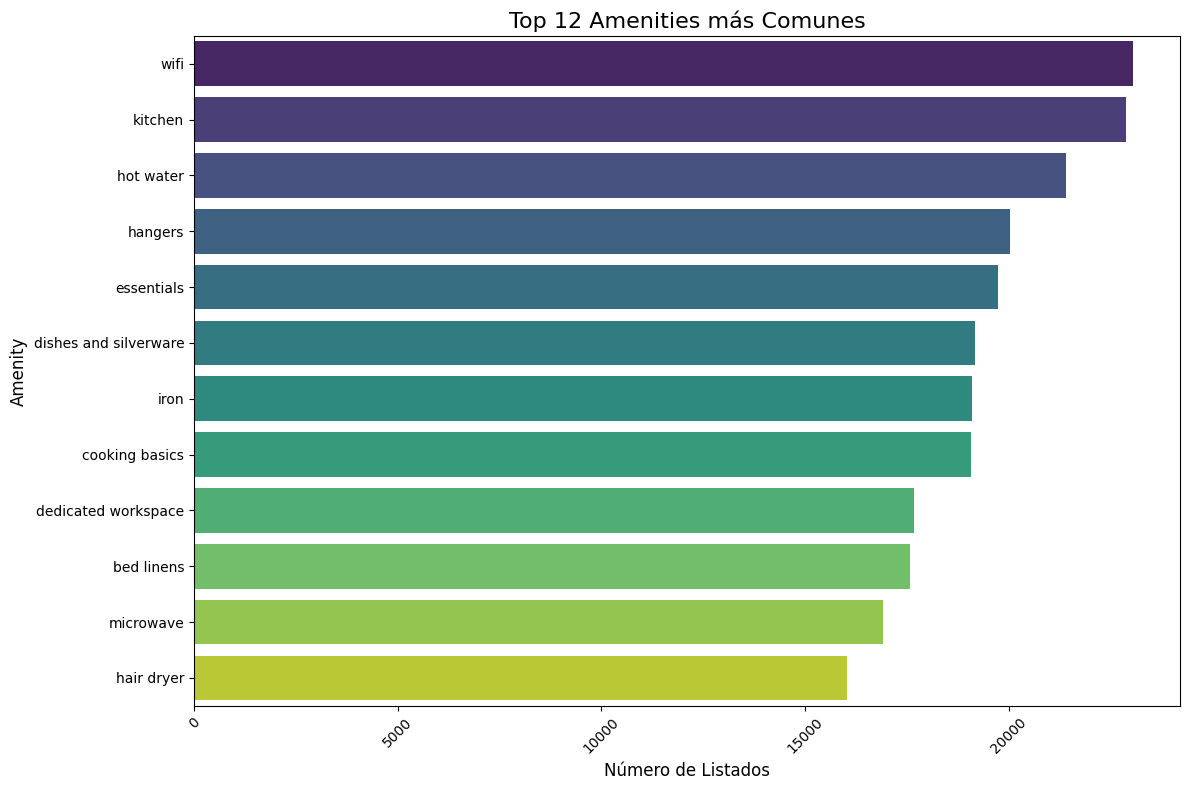

In [175]:
# 1. Contar la frecuencia de cada amenity
amenities_counts = pd.Series(amenities_flat).value_counts()

# 2. Seleccionar las 12 más comunes
top_12_amenities = amenities_counts.head(12)

# 3. Crear la gráfica de barras
plt.figure(figsize=(12, 8))
sns.barplot(x=top_12_amenities.values, y=top_12_amenities.index, palette='viridis')

# 4. Añadir títulos y etiquetas
plt.title('Top 12 Amenities más Comunes', fontsize=16)
plt.xlabel('Número de Listados', fontsize=12)
plt.ylabel('Amenity', fontsize=12)
plt.xticks(rotation=45) # Opcional: rotar etiquetas si se superponen
plt.tight_layout() # Ajusta el gráfico para que todo encaje
plt.show()

#### Análisis columnas cuantitativas

In [176]:
columns_num = df_listings.select_dtypes(include=['number'])
columns_num.head()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
0,35797,20250625031918,153786,1.0,1.0,19.38283,-99.27178,2,1.0,1.0,1.0,1,7,1.0,1.0,7.0,7.0,1.0,7.0,29,59,89,364,0,0,0,188,0,0,0.0,1,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,44616,20250625031918,196253,13.0,13.0,19.41162,-99.17794,14,5.5,5.0,8.0,1,180,1.0,1.0,180.0,180.0,1.0,180.0,29,59,89,360,65,1,0,179,0,6,108000.0,9,4,2,0,4.59,4.56,4.70,4.87,4.78,4.98,4.47,0.39
2,56074,20250625031918,265650,1.0,5.0,19.43977,-99.15605,2,1.0,1.0,1.0,15,250,15.0,15.0,250.0,250.0,15.0,250.0,3,33,63,338,84,1,0,157,0,30,17550.0,1,1,0,0,4.87,4.95,4.88,4.98,4.94,4.76,4.79,0.48
3,67703,20250625031918,334451,3.0,4.0,19.41152,-99.16857,4,1.0,2.0,2.0,2,30,2.0,2.0,30.0,30.0,2.0,30.0,3,4,32,267,50,1,0,97,4,6,10176.0,2,2,0,0,4.90,4.82,4.76,4.94,4.92,4.98,4.92,0.30
4,70644,20250625031918,212109,3.0,4.0,19.35448,-99.16217,2,1.0,1.0,1.0,3,180,3.0,4.0,180.0,180.0,3.4,180.0,10,25,25,211,132,8,0,98,9,48,48192.0,3,2,1,0,4.92,4.91,4.96,4.96,4.98,4.96,4.92,0.81


### Calidad de los datos

#### Valores nulos

In [177]:
df_listings.isnull().sum()

id                                                  0
listing_url                                         0
scrape_id                                           0
last_scraped                                        0
source                                              0
name                                                0
description                                       768
neighborhood_overview                           12431
picture_url                                         0
host_id                                             0
host_url                                            0
host_name                                         857
host_since                                        914
host_location                                    6237
host_about                                      11237
host_response_time                                914
host_response_rate                                914
host_acceptance_rate                              914
host_is_superhost           

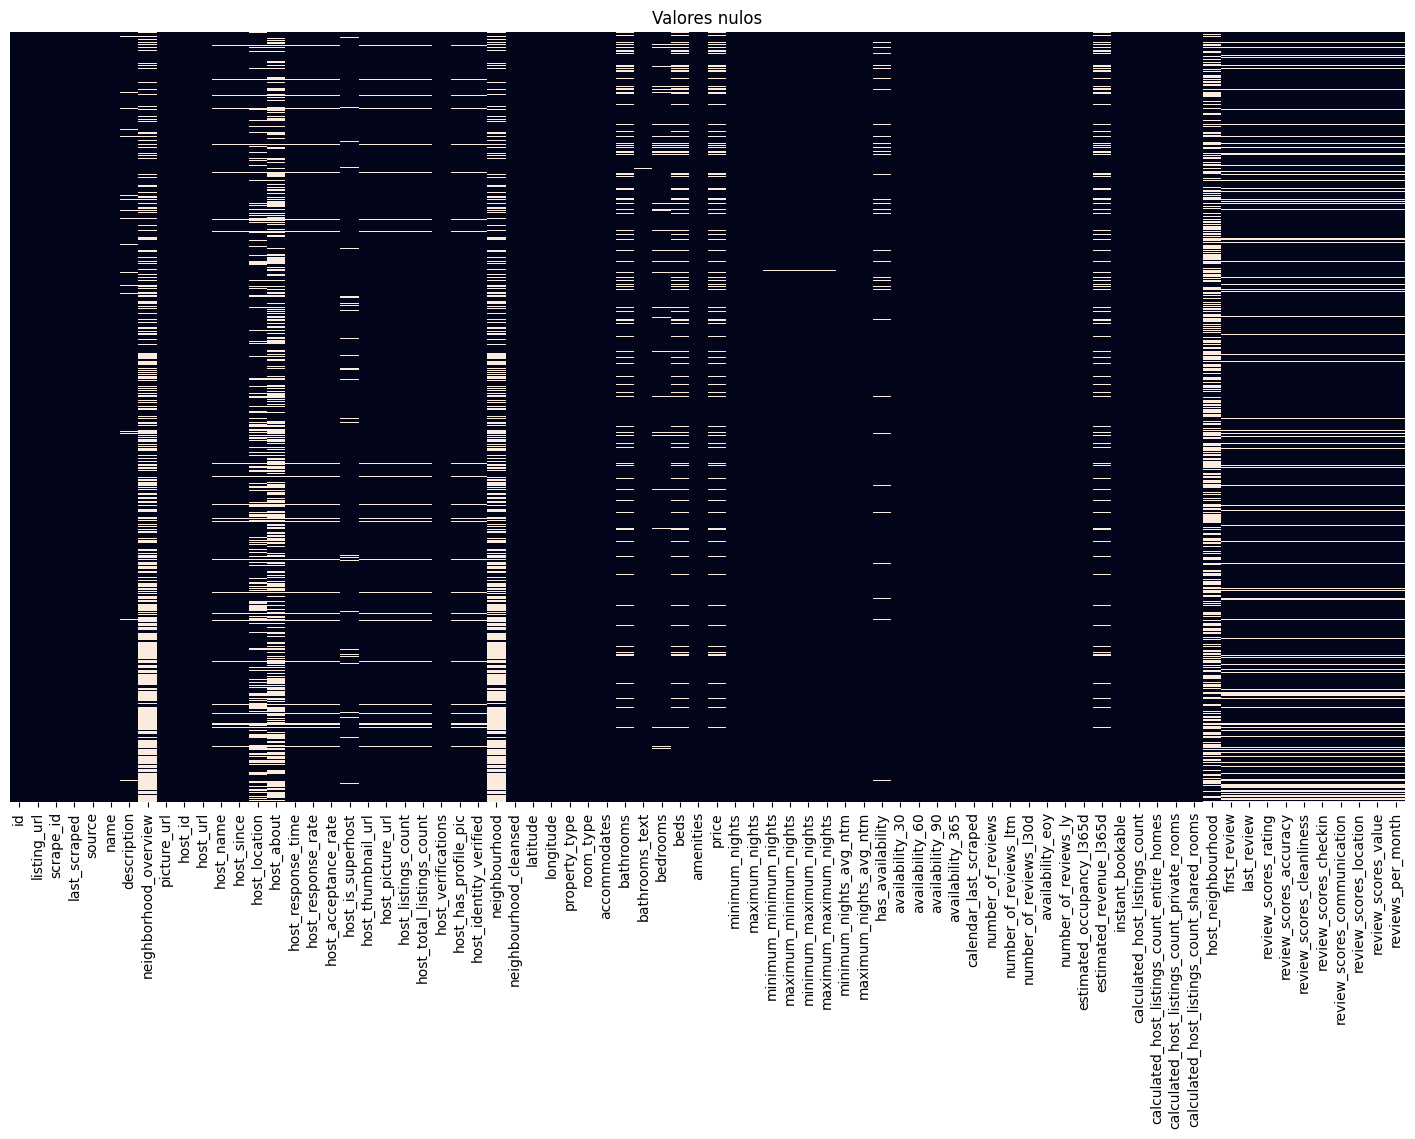

In [178]:
plt.figure(figsize=(18, 10))
sns.heatmap(df_listings.isnull(), cbar=False, yticklabels=False)
plt.title('Valores nulos')
plt.show()

In [179]:
stats = df_listings.describe().T
display(stats.round(2))

,count,mean,min,25%,50%,75%,max,std
id,26401.0,648852152493424640.0,35797.0,42559924.0,782141463665240320.0,1148083819557682432.0,1450438287340754688.0,548355810528733760.0
scrape_id,26401.0,20250625031918.0,20250625031918.0,20250625031918.0,20250625031918.0,20250625031918.0,20250625031918.0,0.0
last_scraped,26401,2025-06-29 01:38:27.048975360,2025-06-25 00:00:00,2025-06-27 00:00:00,2025-06-30 00:00:00,2025-07-01 00:00:00,2025-07-02 00:00:00,NaN
host_id,26401.0,235411243.311428,7365.0,54364774.0,170583300.0,416155974.0,703177347.0,200584387.527188
host_since,25487,2018-08-25 18:28:14.134264576,2009-02-03 00:00:00,2016-02-03 00:00:00,2018-01-31 00:00:00,2021-08-16 00:00:00,2025-06-24 00:00:00,NaN
host_listings_count,25487.0,24.467022,1.0,1.0,4.0,14.0,896.0,82.394384
host_total_listings_count,25487.0,33.189822,1.0,2.0,5.0,17.0,946.0,115.57014
latitude,26401.0,19.405311,19.177848,19.39188,19.41512,19.431892,19.56101,0.042498
longitude,26401.0,-99.165638,-99.33963,-99.178614,-99.16726,-99.153975,-98.96336,0.033679
accommodates,26401.0,3.333434,1.0,2.0,2.0,4.0,16.0,2.338818


#### Análisis de valores atípicos

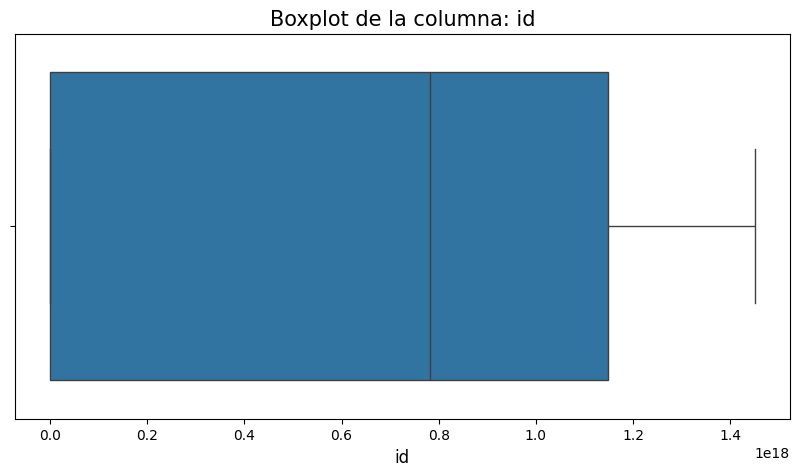

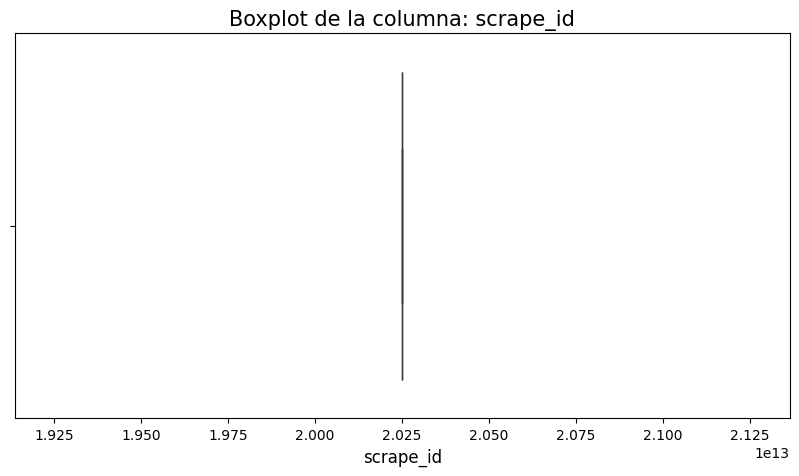

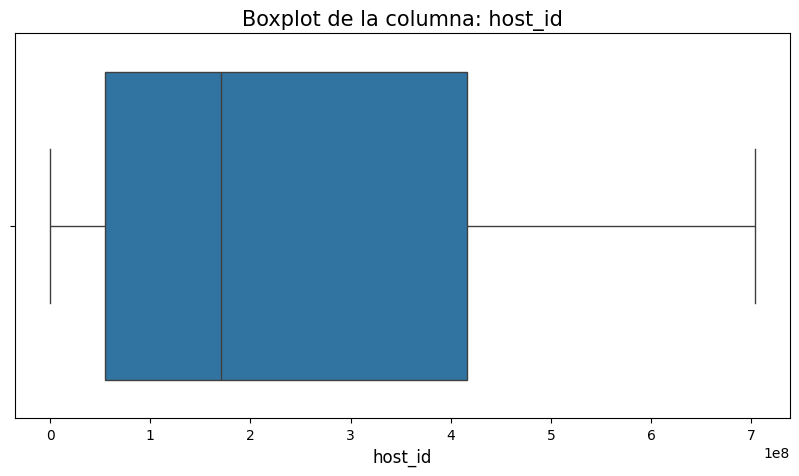

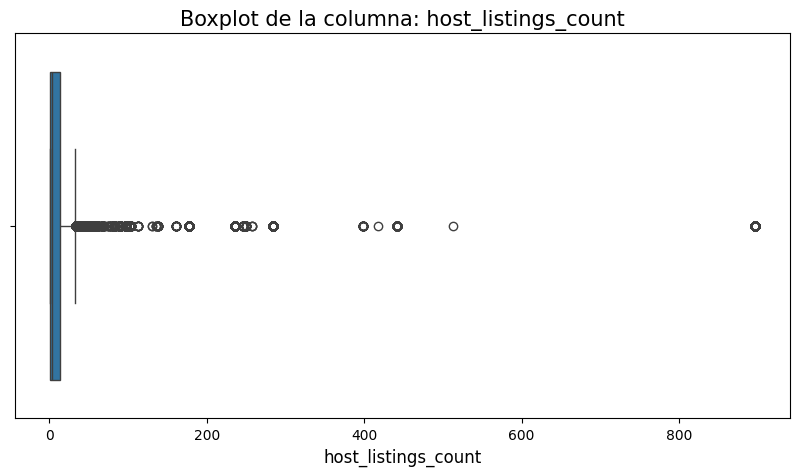

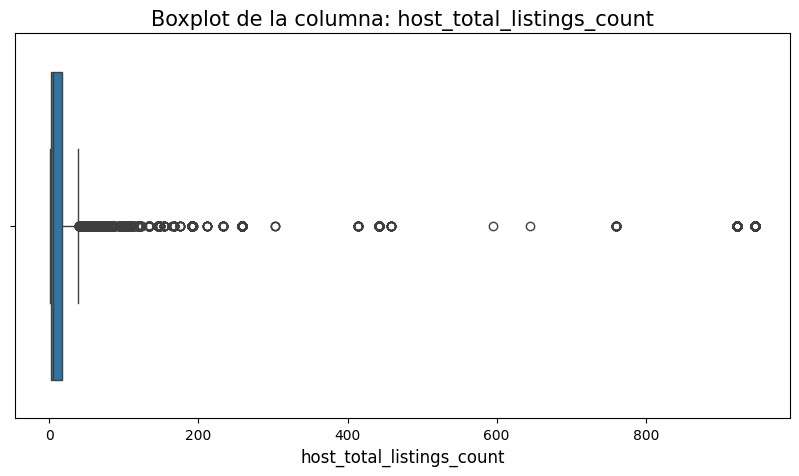

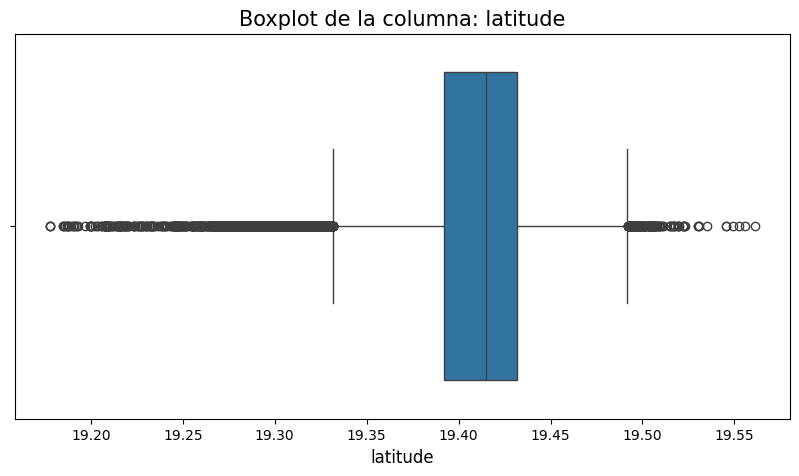

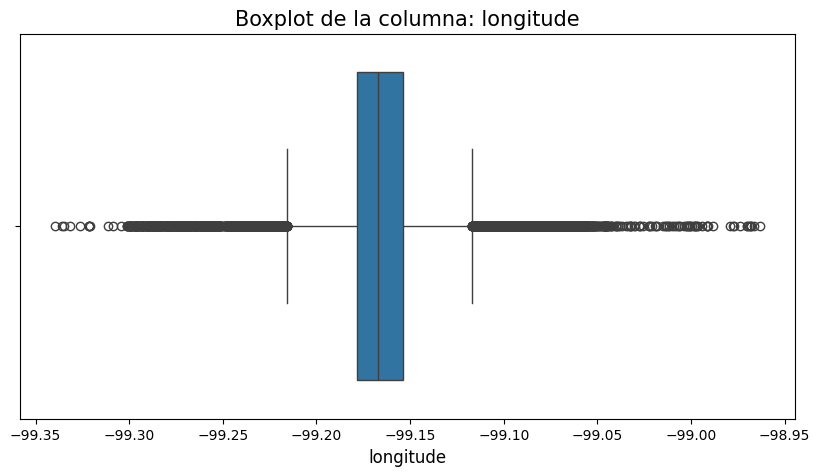

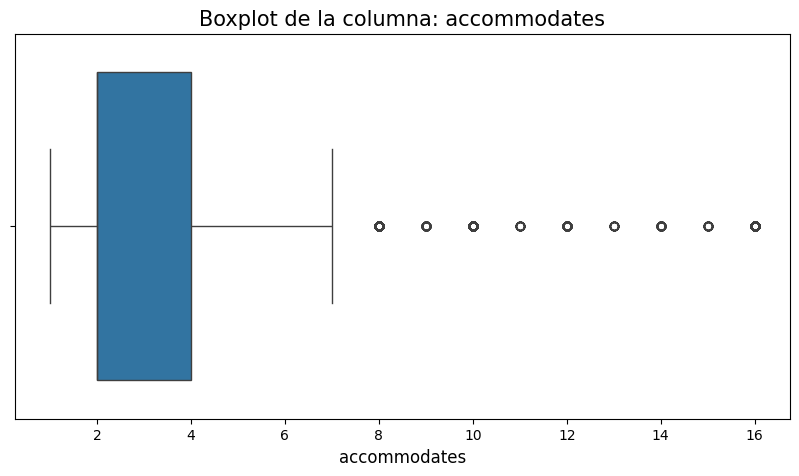

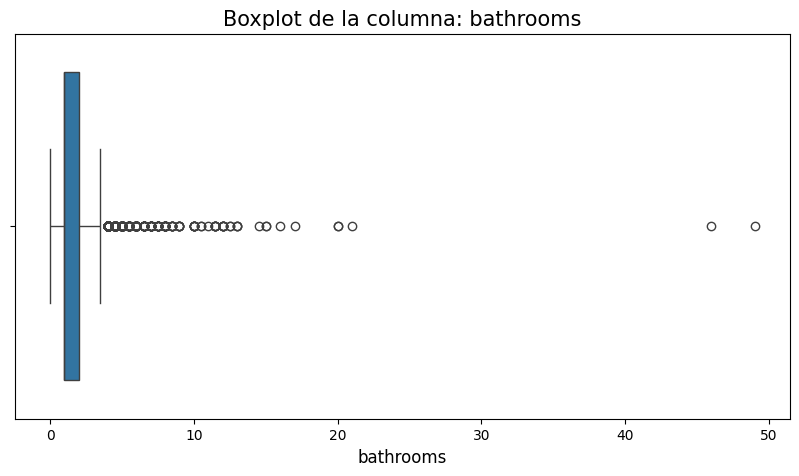

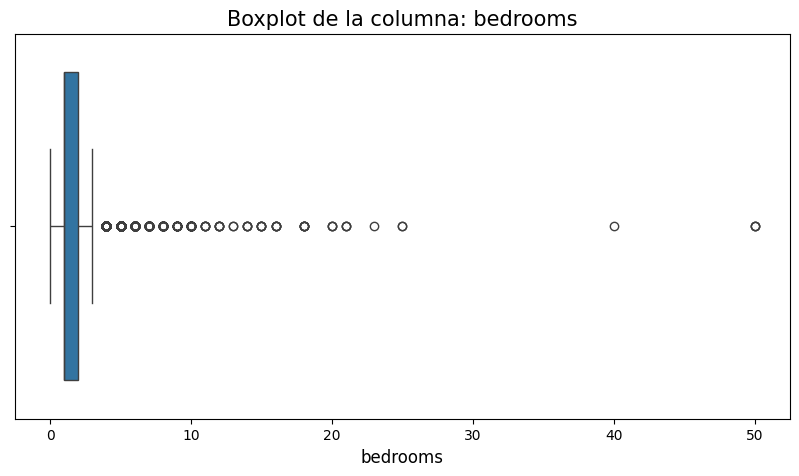

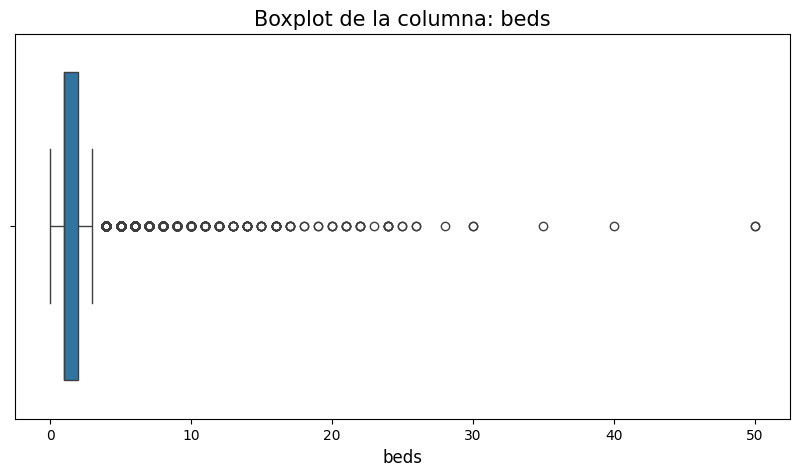

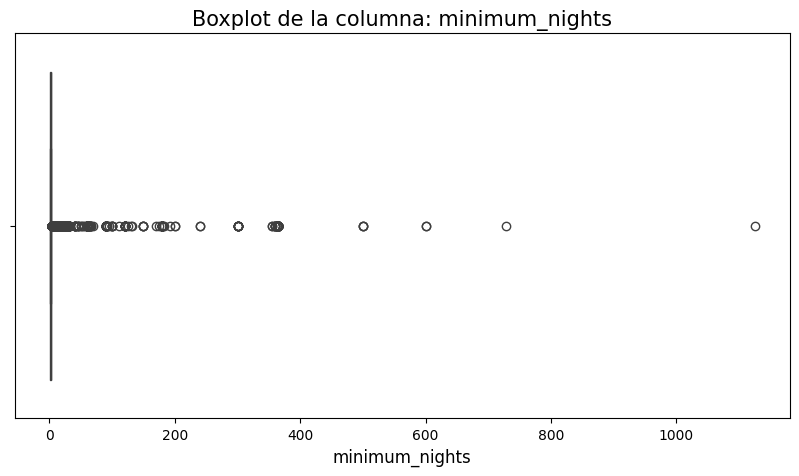

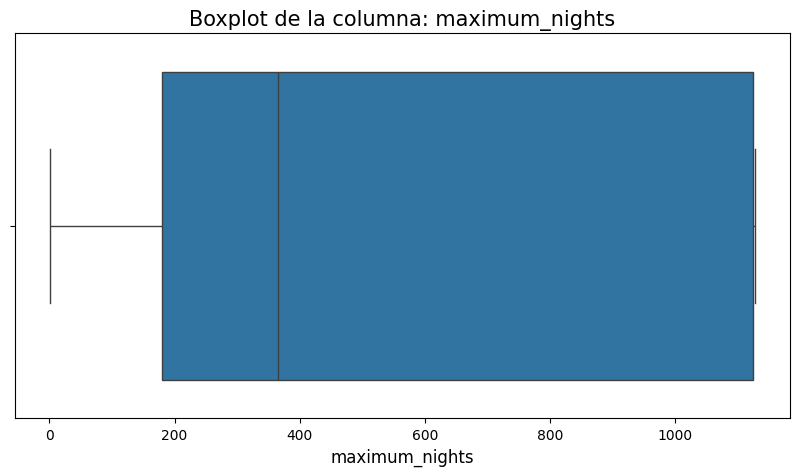

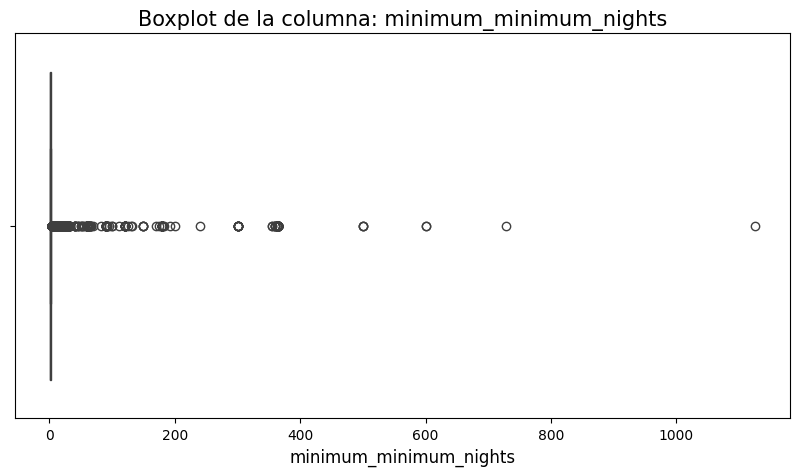

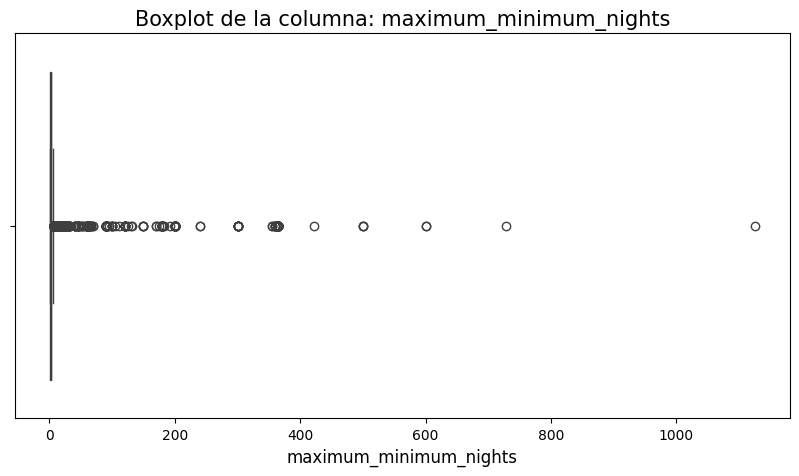

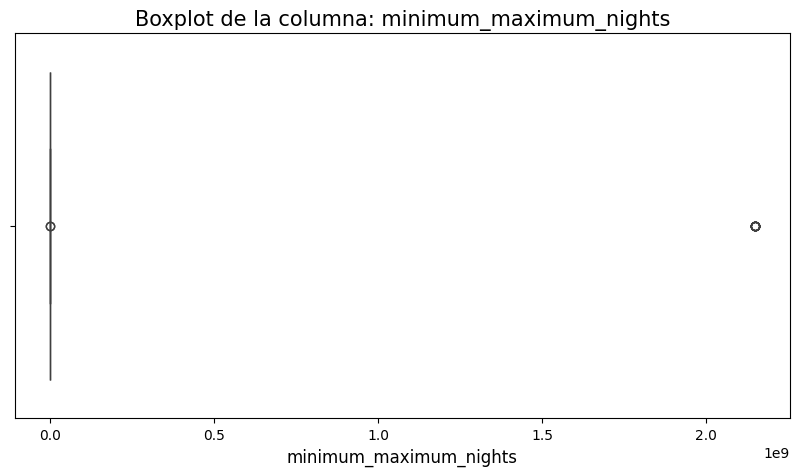

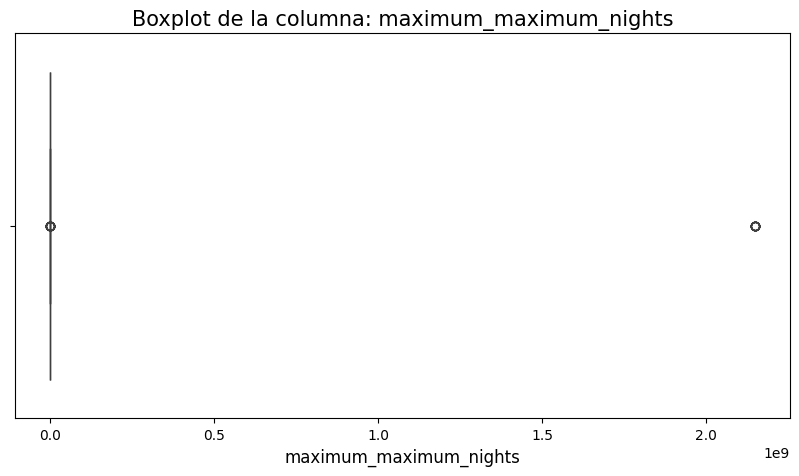

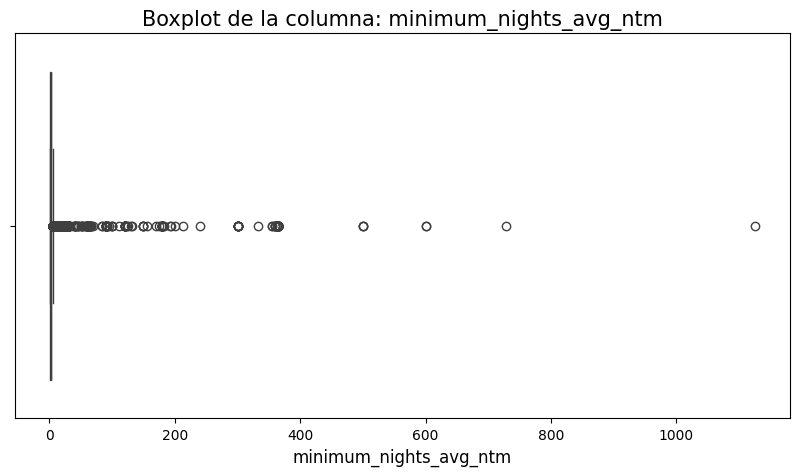

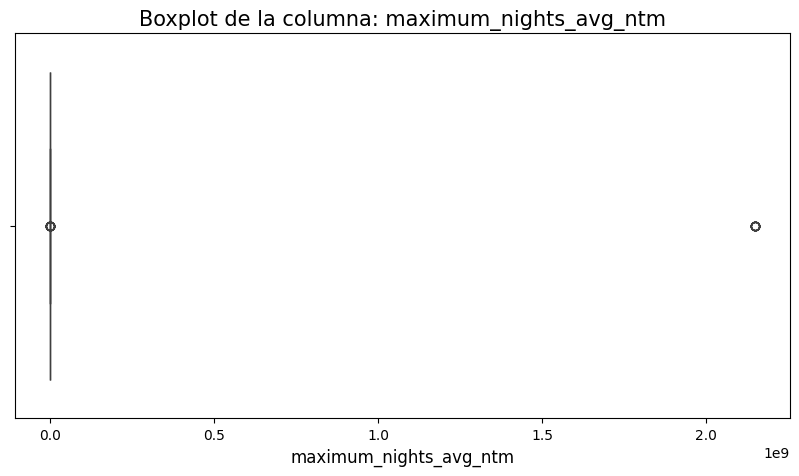

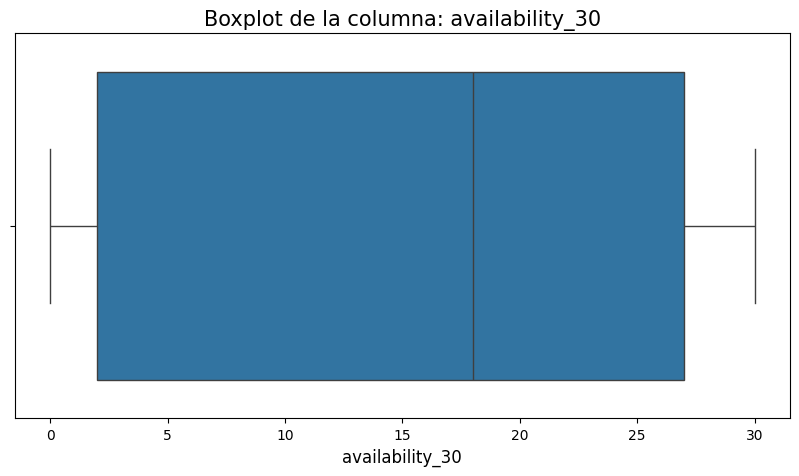

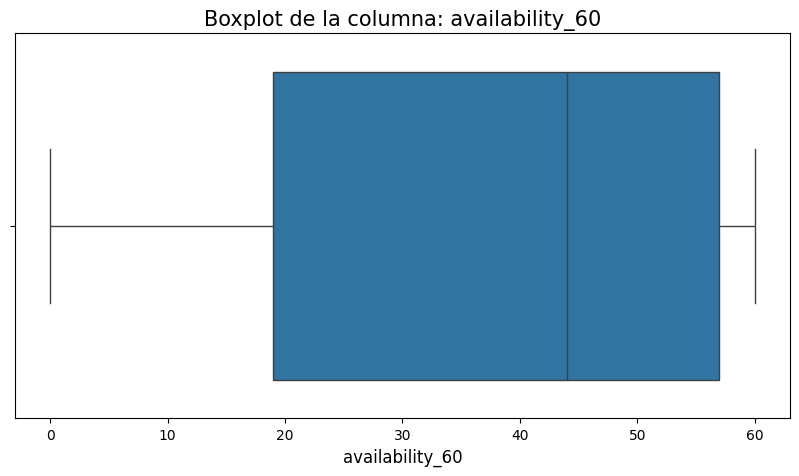

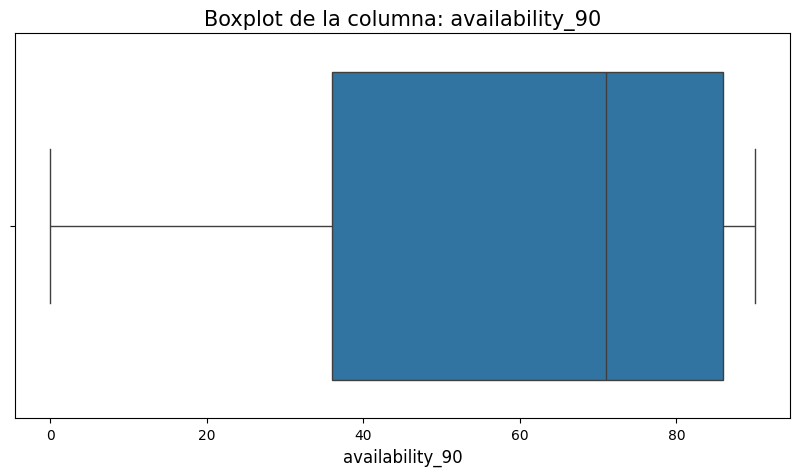

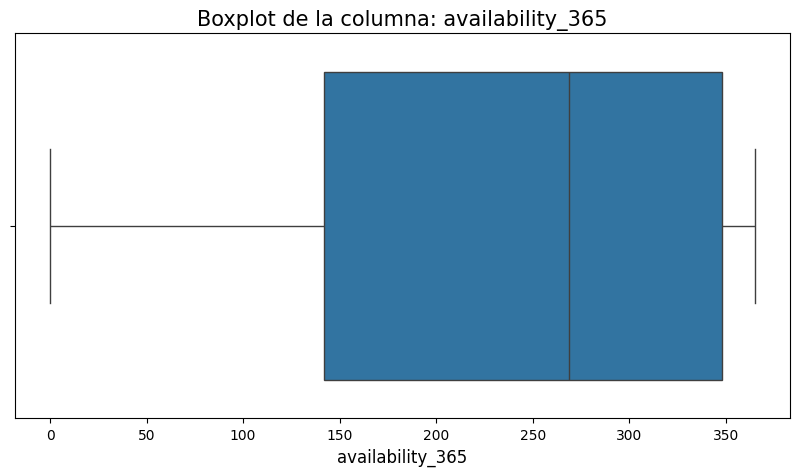

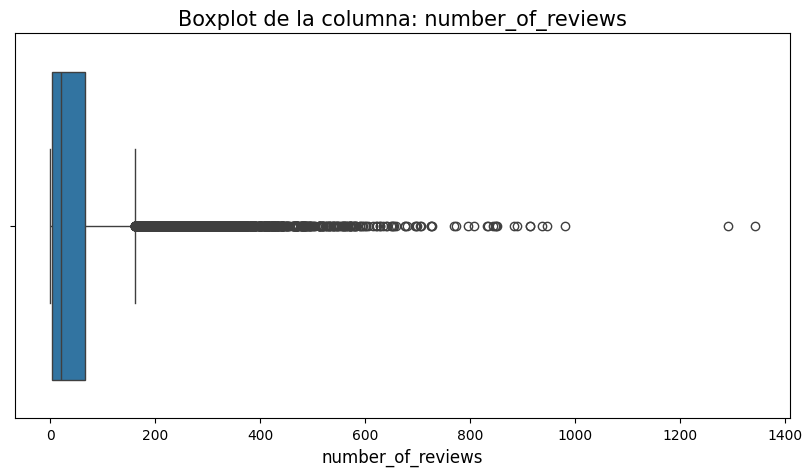

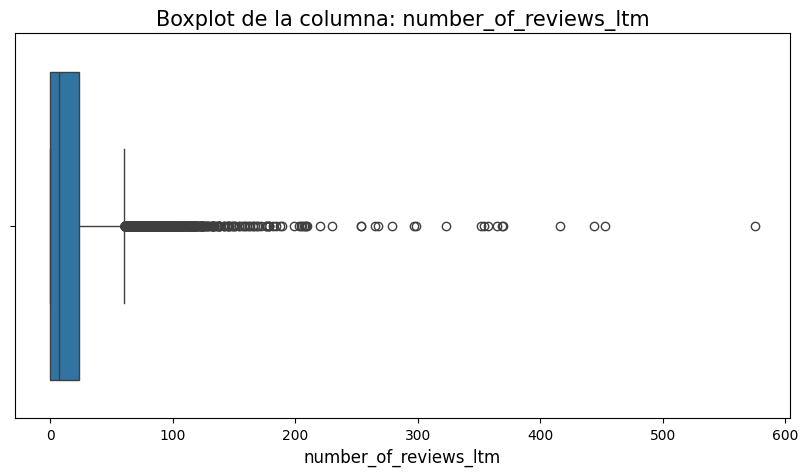

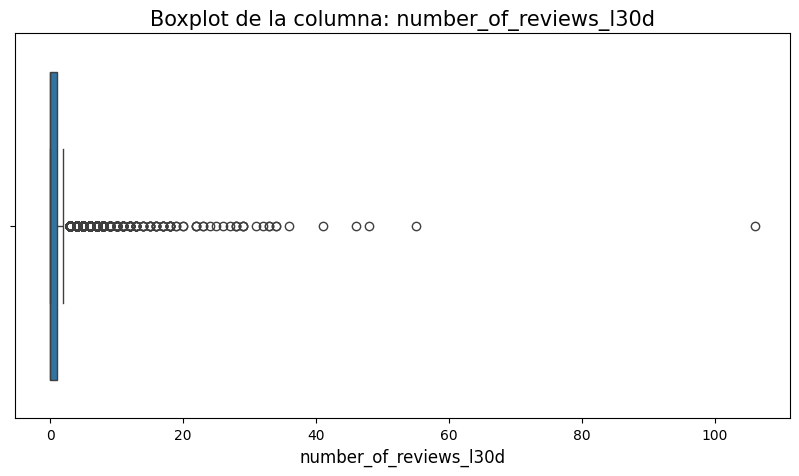

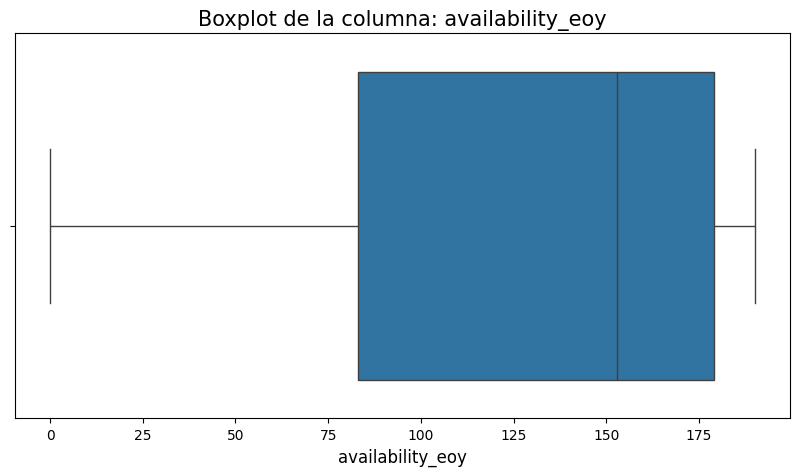

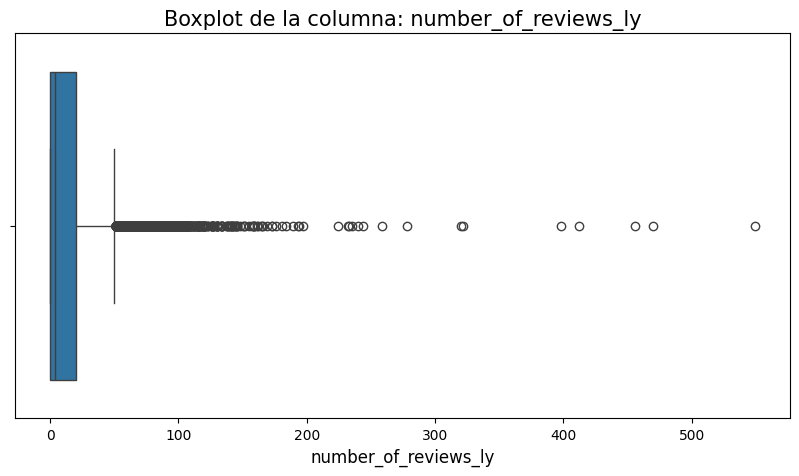

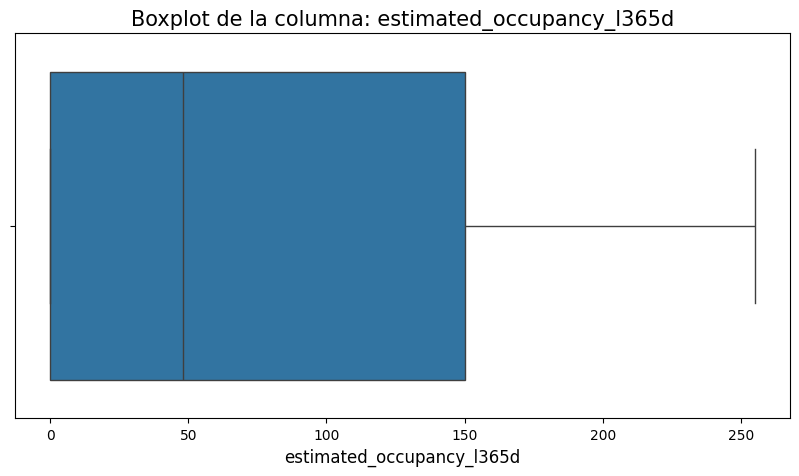

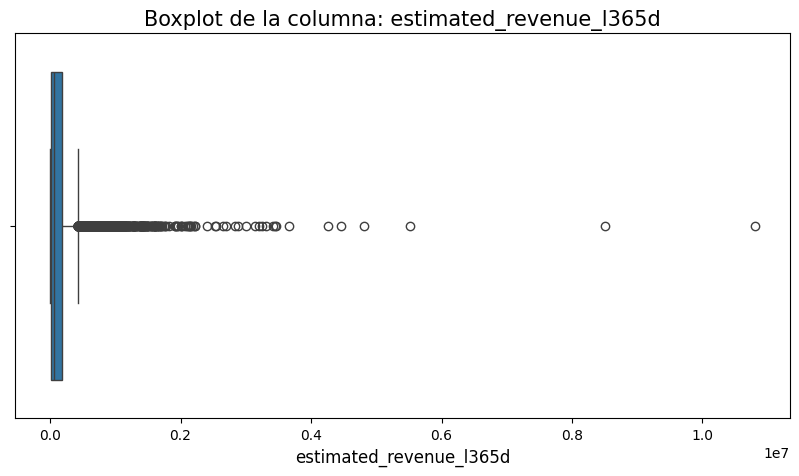

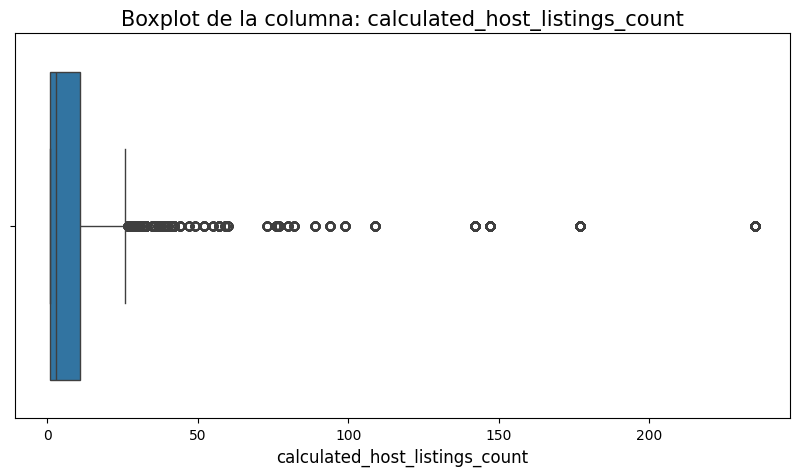

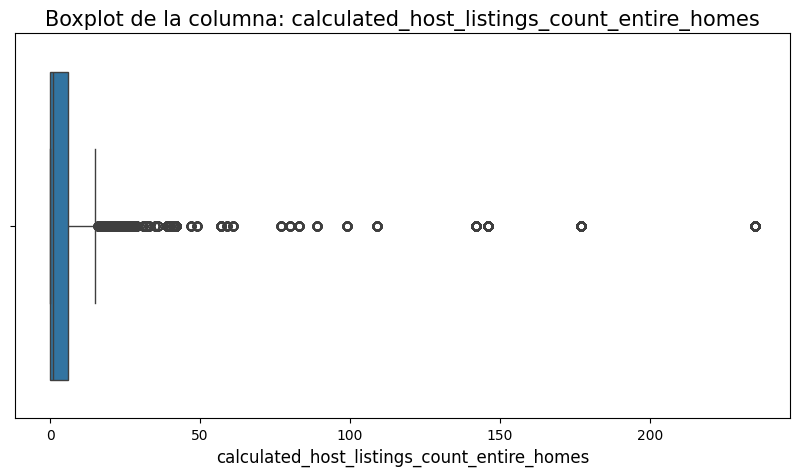

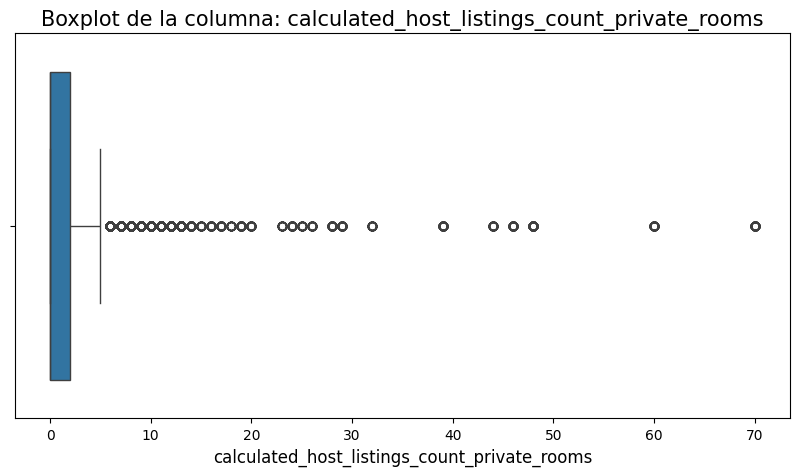

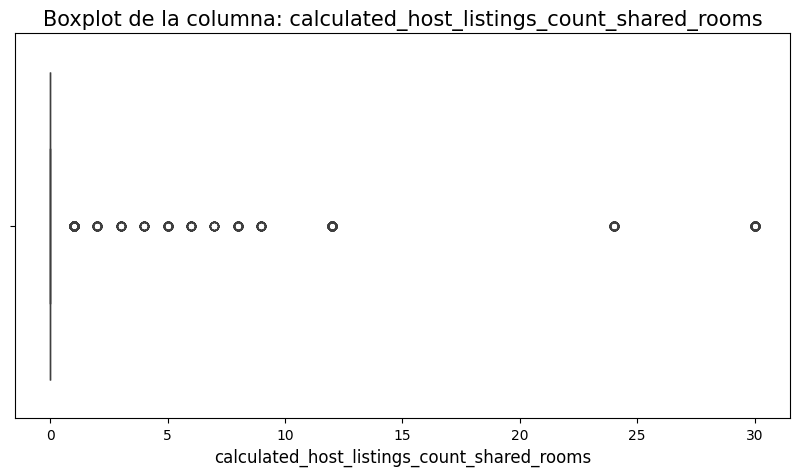

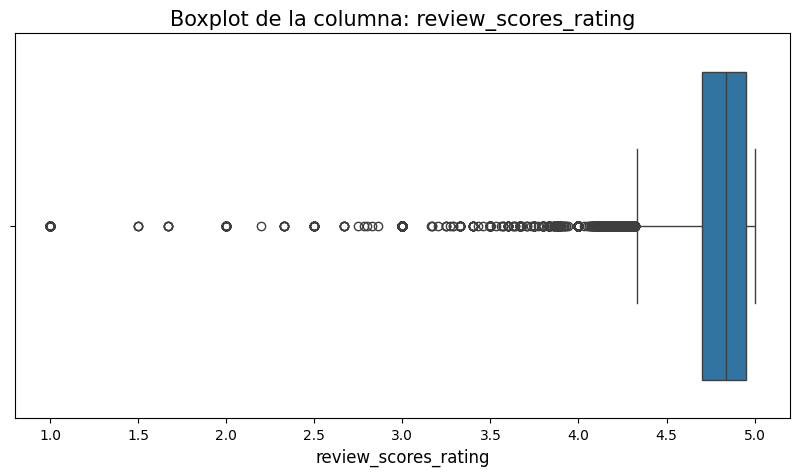

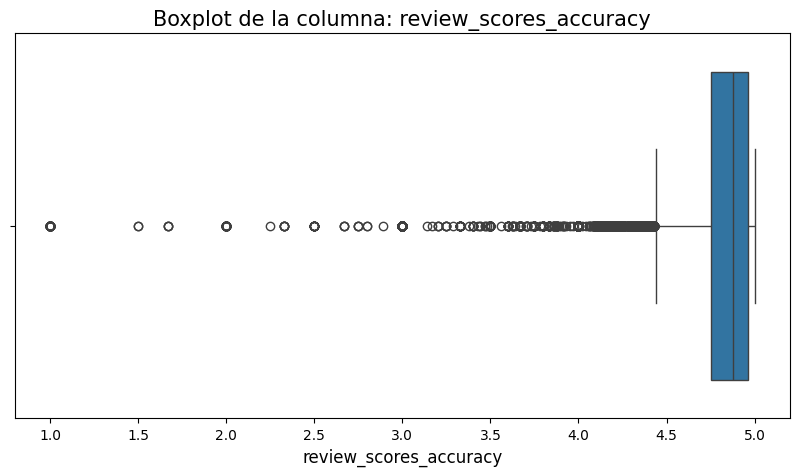

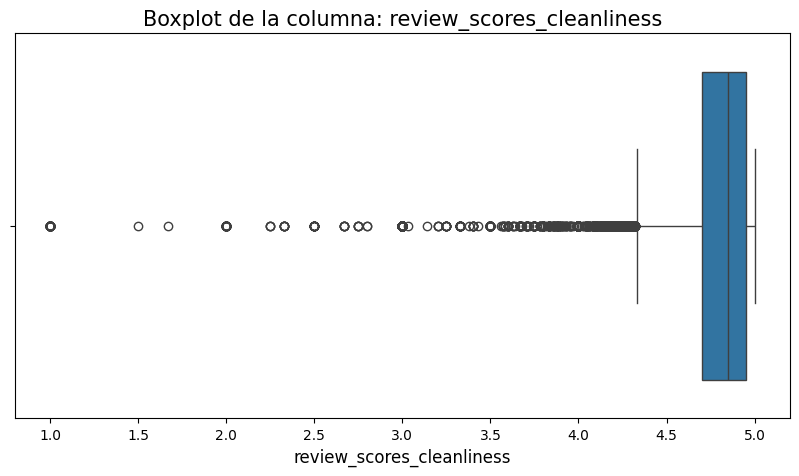

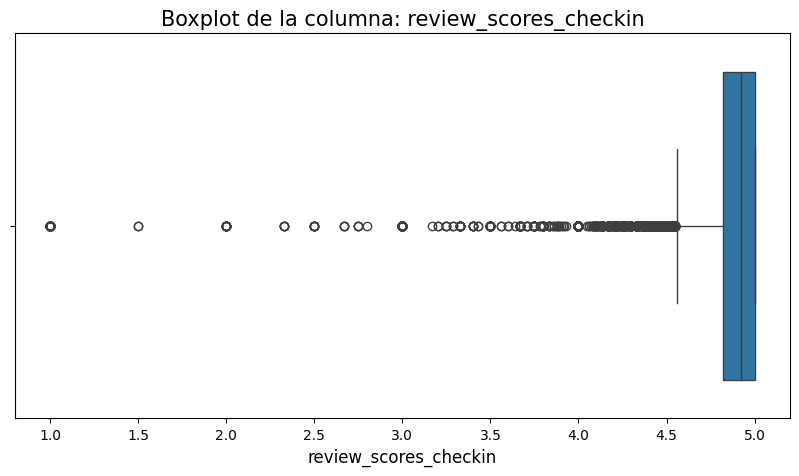

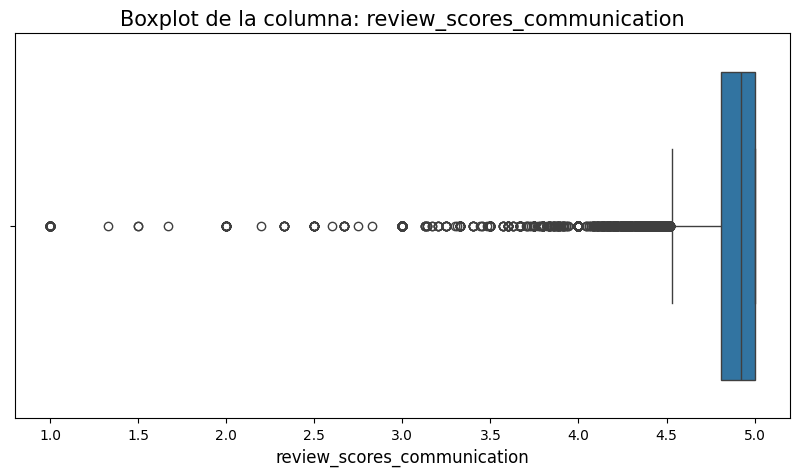

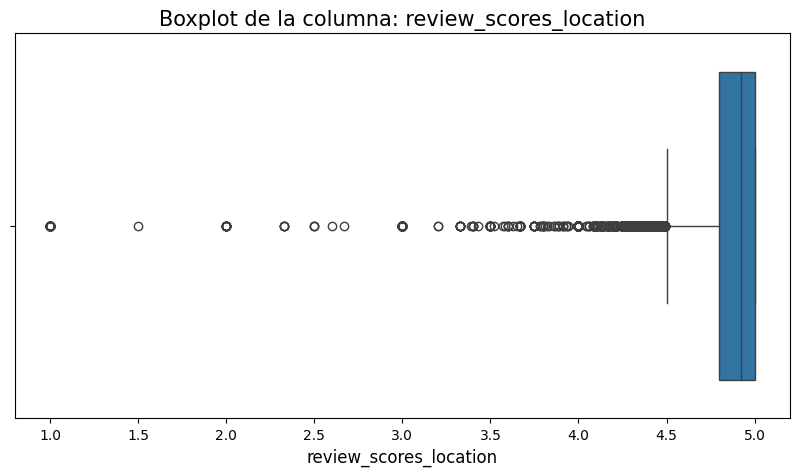

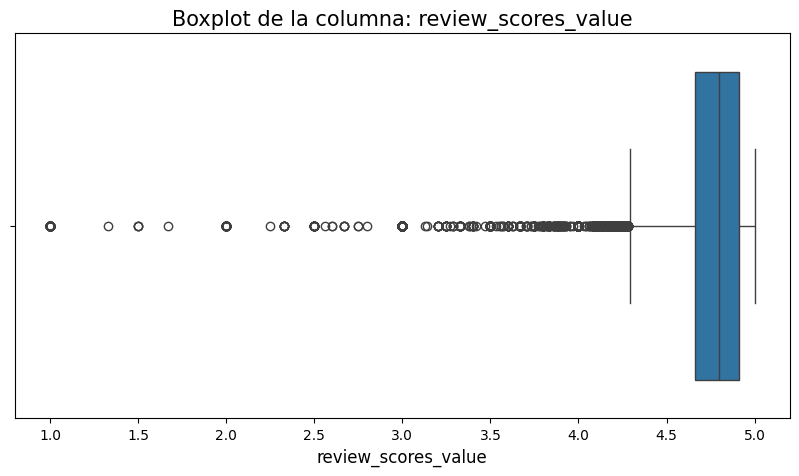

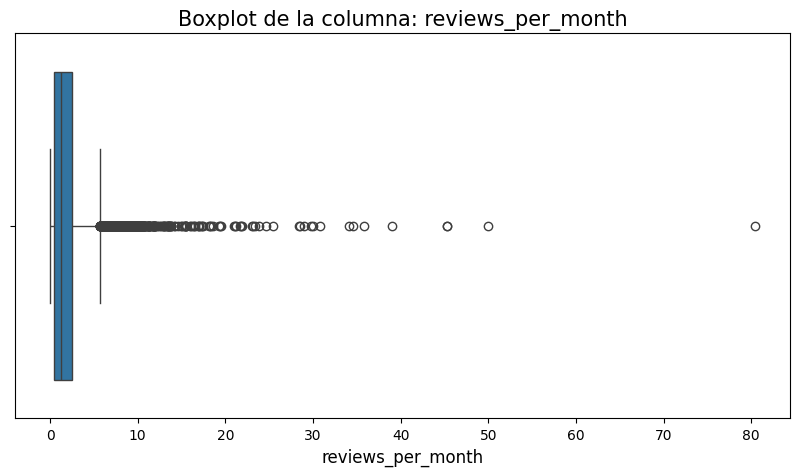

In [180]:
for column in columns_num:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=df_listings[column])
    plt.title(f'Boxplot de la columna: {column}', fontsize=15)
    plt.xlabel(column, fontsize=12)
    plt.show()

In [181]:
num_duplicados = df_listings.duplicated("id").sum()
print(f"Número de filas duplicadas encontradas: {num_duplicados}")

Número de filas duplicadas encontradas: 0


### Transformaciones Potenciales

In [293]:
df_trans = df_listings.copy()

#### Eliminar '%' en host_response_rate y host_acceptance_rate

In [294]:
# Columnas a modificar
columnas_porcentaje = ['host_response_rate', 'host_acceptance_rate']

# Bucle para limpiar y convertir las columnas
for col in columnas_porcentaje:
    df_trans[col] = df_trans[col].str.replace('%', '', regex=False)
    df_trans[col] = pd.to_numeric(df_trans[col], errors='coerce')

# Opcional: Verificar el tipo de dato y los primeros valores
print("Tipos de datos después de la transformación:")
print(df_trans[columnas_porcentaje].dtypes)
print("\nPrimeros valores de las columnas transformadas:")
display(df_trans[columnas_porcentaje].head())

Tipos de datos después de la transformación:
host_response_rate      float64
host_acceptance_rate    float64
dtype: object

Primeros valores de las columnas transformadas:


,host_response_rate,host_acceptance_rate
0,NaN,NaN
1,100.0,91.0
2,100.0,100.0
3,100.0,47.0
4,100.0,85.0


#### Categorizar host_response_time

In [295]:
# Definir el mapeo de categorías
response_time_map = {
    'within an hour': 'Fast',
    'within a few hours': 'Fast',
    'within a day': 'Moderate',
    'a few days or more': 'Slow'
}

# Aplicar el mapeo para crear la nueva columna 'host_response_speed'
df_trans['host_response_speed'] = df_trans['host_response_time'].map(response_time_map)

# Rellenar valores faltantes con una categoría explícita
df_trans['host_response_speed'].fillna('Unknown', inplace=True)

# Verificar el resultado
print("Mapeo de 'host_response_time' a 'host_response_speed':")
display(df_trans[['host_response_time', 'host_response_speed']].head(10))
print("\nConteo de las nuevas categorías:")
print(df_trans['host_response_speed'].value_counts())

Mapeo de 'host_response_time' a 'host_response_speed':


,host_response_time,host_response_speed
0,N/A,Unknown
1,within an hour,Fast
2,within a few hours,Fast
3,within a few hours,Fast
4,within a few hours,Fast
5,N/A,Unknown
6,within an hour,Fast
7,within an hour,Fast
8,within an hour,Fast
9,N/A,Unknown



Conteo de las nuevas categorías:
host_response_speed
Fast        19743
Unknown      4686
Moderate     1060
Slow          912
Name: count, dtype: int64


#### Desanidar campos

In [296]:
# Convertir la lista de texto a lista real
df_trans['host_verifications'] = df_trans['host_verifications'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# Reemplazar valores nulos por listas vacías
df_trans['host_verifications'] = df_trans['host_verifications'].apply(lambda x: x if isinstance(x, list) else [])

# Crear columnas binarias
df_verifications = df_trans['host_verifications'].apply(lambda x: pd.Series(1, index=x)).fillna(0).astype(int)

# Renombrar columnas: prefijo "verif_"
df_verifications.columns = [f"verif_{col}" for col in df_verifications.columns]

# Unir al dataframe original sin perder transformaciones previas
df_trans = pd.concat([df_trans, df_verifications], axis=1)

df_trans = df_trans.drop(columns=['host_verifications'])
# Verificar resultado
display(df_trans.filter(like='verif_').head())

,verif_email,verif_phone,verif_work_email
0,1,1,1
1,1,1,1
2,1,1,0
3,1,1,0
4,1,1,1


In [297]:
# Normalizar y codificar amenities
def parse_amenities(value):
    if isinstance(value, list):
        return value
    if isinstance(value, str):
        try:
            parsed = ast.literal_eval(value)
            if isinstance(parsed, list):
                return parsed
        except (ValueError, SyntaxError):
            pass
        return [amen.strip() for amen in value.split(',') if amen.strip()]
    return []

df_trans['amenities_list'] = (
    df_trans['amenities']
    .apply(parse_amenities)
    .apply(lambda items: [str(amen).strip().lower() for amen in items if amen])
)

all_amenities = df_trans['amenities_list'].explode()
top_12_amenities = [amen for amen, _ in Counter(all_amenities).most_common(12)]

for amen in top_12_amenities:
    safe_name = amen.replace(' ', '_').replace('/', '_')
    col_name = f"amen_{safe_name}"
    df_trans[col_name] = df_trans['amenities_list'].apply(lambda x: int(amen in x))

df_trans['amenities_count'] = df_trans['amenities_list'].apply(len)

# Eliminar columnas auxiliares
df_trans.drop(columns=['amenities', 'amenities_list'], inplace=True, errors='ignore')

print("\nDataFrame con las nuevas columnas de amenities (primeras 5 filas):")
display(df_trans.filter(like='amen_').head())


DataFrame con las nuevas columnas de amenities (primeras 5 filas):


,amen_wifi,amen_kitchen,amen_hot_water,amen_hangers,amen_essentials,amen_dishes_and_silverware,amen_iron,amen_cooking_basics,amen_dedicated_workspace,amen_bed_linens,amen_microwave,amen_hair_dryer
0,1,1,1,0,0,0,0,0,0,1,0,0
1,1,1,0,1,1,1,1,1,0,0,1,1
2,1,1,1,1,1,1,1,1,0,1,1,0
3,1,1,1,1,1,1,1,0,1,1,0,0
4,1,1,1,1,1,1,1,1,1,1,1,1


#### Eliminacion del '$' en price

In [298]:
# Limpiar la columna 'price' preservando los decimales
if 'price' in df_trans.columns:
    df_trans['price'] = (
        df_trans['price']
        .astype(str)
        .str.replace(r'[\$,]', '', regex=True)
        .str.strip()
    )
    df_trans['price'] = pd.to_numeric(df_trans['price'], errors='coerce')

display(df_trans[['price']].head())

,price
0,3799.0
1,18000.0
2,585.0
3,1696.0
4,1004.0


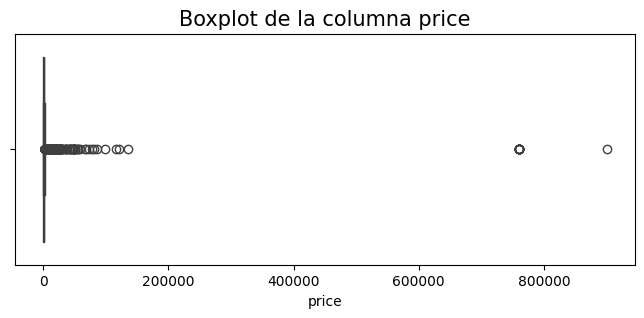

In [299]:
plt.figure(figsize=(8, 3))
sns.boxplot(x=df_trans['price'])
plt.title(f'Boxplot de la columna price', fontsize=15)
plt.show()

In [300]:
# Eliminar filas donde el precio no sea válido (NaN) después de la conversión
df_trans.dropna(subset=['price'], inplace=True)
# Eliminar outliers en 'price' 
# 2. Calcular los límites para detectar outliers
Q1 = df_trans['price'].quantile(0.25)
Q3 = df_trans['price'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR


# 3. Filtrar el DataFrame para mantener solo los valores dentro de los límites
filas_antes = df_trans.shape[0]
df_trans_sin_outliers = df_trans[
    (df_trans['price'] >= limite_inferior) & (df_trans['price'] <= limite_superior)
].copy() # .copy() para evitar SettingWithCopyWarning
filas_despues = df_trans_sin_outliers.shape[0]


# 4. Mostrar un resumen de la operación
print(f"Límites de precio para la detección de outliers:")
print(f"  - Límite inferior: ${limite_inferior:,.2f}")
print(f"  - Límite superior: ${limite_superior:,.2f}")
print("-" * 40)
print(f"Filas antes de eliminar outliers: {filas_antes}")
print(f"Filas después de eliminar outliers: {filas_despues}")
print(f"Número de outliers de 'price' eliminados: {filas_antes - filas_despues}")

Límites de precio para la detección de outliers:
  - Límite inferior: $-895.50
  - Límite superior: $3,172.50
----------------------------------------
Filas antes de eliminar outliers: 23127
Filas después de eliminar outliers: 21375
Número de outliers de 'price' eliminados: 1752


#### Limpieza en Neighbourhood

In [301]:
# 1. Función para quitar acentos (la misma de antes, es útil)
def remove_accents(input_str):
    if not isinstance(input_str, str):
        return input_str
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return "".join([c for c in nfkd_form if not unicodedata.combining(c)])

# 2. Extraer la primera parte del texto (el barrio) y luego limpiar
# .str.split(',').str.get(0) divide por la coma y toma el primer elemento.
df_trans['neighbourhood_cleaned'] = df_trans['neighbourhood'] \
    .str.split(',') \
    .str.get(0) \
    .apply(remove_accents) \
    .str.lower() \
    .str.strip()

# 3. (Opcional) Mostrar la comparación para ver la mejora
print("Comparación del método mejorado (extrayendo antes de limpiar):")
display(df_trans[['neighbourhood', 'neighbourhood_cleaned']].drop_duplicates().head(15))

print("\nConteo de los 10 barrios más comunes con el nuevo método:")
print(df_trans['neighbourhood_cleaned'].value_counts().head(10))

Comparación del método mejorado (extrayendo antes de limpiar):


,neighbourhood,neighbourhood_cleaned
0,"Mexico City, D.f., Mexico",mexico city
1,NaN,NaN
2,"Mexico City, DF, Mexico",mexico city
4,"Mexico City, Federal District, Mexico",mexico city
8,"Colonia Juárez, Ciudad de México, Mexico",colonia juarez
17,"Mexico City, Mexico",mexico city
49,"Mexico , Cuauhtemoc, Mexico",mexico
81,"Pensador Mexicano, Ciudad de México, Mexico",pensador mexicano
98,"México, D.F., Mexico",mexico
104,"Col. Anáhuac I, Miguel Hidalgo , Distrito Fede...",col. anahuac i



Conteo de los 10 barrios más comunes con el nuevo método:
neighbourhood_cleaned
mexico city         11514
centro                194
juarez                135
ciudad de mexico       36
del valle norte        33
colonia juarez         30
cuauhtemoc             27
coyoacan               23
hipodromo              22
mexico                 20
Name: count, dtype: int64


#### Normalización de bathrooms

In [302]:
# Función para extraer el número de baños desde el texto
def parse_bathrooms_text(text):
    if pd.isna(text):
        return np.nan
    
    text_lower = str(text).lower()
    
    # Caso especial para "half-bath" o "shared half-bath"
    if 'half-bath' in text_lower:
        return 0.5
    
    # Extraer el primer número que se encuentre en el texto
    # (funciona para "1 bath", "2.5 baths", etc.)
    match = pd.Series(text_lower).str.extract(r'(\d+\.?\d*)', expand=False).iloc[0]
    if pd.notna(match):
        return float(match)
        
    return np.nan

# Rellenar los valores nulos de 'bathrooms' usando 'bathrooms_text'
# .copy() para evitar advertencias de pandas
df_trans_copy = df_trans.copy()

# Aplica la función a 'bathrooms_text' para obtener los números
extracted_baths = df_trans_copy['bathrooms_text'].apply(parse_bathrooms_text)

# Rellena los NaN en 'bathrooms' con los valores extraídos
df_trans_copy['bathrooms'].fillna(extracted_baths, inplace=True)

# Rellenar los nulos restantes con la mediana (estrategia robusta)
# Si después de usar bathrooms_text aún quedan nulos, la mediana es una buena opción
if df_trans_copy['bathrooms'].isnull().any():
    bathrooms_median = df_trans_copy['bathrooms'].median()
    df_trans_copy['bathrooms'].fillna(bathrooms_median, inplace=True)
    print(f"Los nulos restantes se rellenaron con la mediana: {bathrooms_median}")

# Reasignar el DataFrame limpio
df_trans = df_trans_copy

# Verificar el resultado
print("\nConteo de valores nulos en 'bathrooms' después de la limpieza:")
print(df_trans['bathrooms'].isnull().sum())

print("\nDistribución de la columna 'bathrooms' actualizada:")
print(df_trans['bathrooms'].value_counts().sort_index().head())

Los nulos restantes se rellenaron con la mediana: 1.0

Conteo de valores nulos en 'bathrooms' después de la limpieza:
0

Distribución de la columna 'bathrooms' actualizada:
bathrooms
0.0      125
0.5       84
1.0    14997
1.5     1551
2.0     4226
Name: count, dtype: int64


In [303]:
df_trans['bathrooms'].unique()

array([ 1. ,  5.5,  5. ,  1.5,  2. ,  4.5,  6. ,  3.5,  2.5,  0.5,  3. ,
       46. , 10. ,  0. ,  7. , 20. ,  4. , 16. , 49. ,  8.5,  9. ,  7.5,
        8. , 12. ,  6.5, 15. , 13. , 17. , 14.5, 12.5, 11.5, 11. , 10.5,
       21. ])

In [304]:
# Calcular los límites para la detección de outliers
Q1_baths = df_trans['bathrooms'].quantile(0.25)
Q3_baths = df_trans['bathrooms'].quantile(0.75)
IQR_baths = Q3_baths - Q1_baths
limite_superior_baths = Q3_baths + 1.5 * IQR_baths
limite_inferior_baths = Q1_baths - 1.5 * IQR_baths

print(f"Límites para 'bathrooms':")
print(f"  - Límite inferior: {limite_inferior_baths}")
print(f"  - Límite superior: {limite_superior_baths}")

# Filtrar el DataFrame, manteniendo solo los valores dentro de los límites
filas_antes = df_trans.shape[0]
df_trans = df_trans[
    (df_trans['bathrooms'] >= limite_inferior_baths) & 
    (df_trans['bathrooms'] <= limite_superior_baths)
].copy()
filas_despues = df_trans.shape[0]

print(f"\nSe eliminaron {filas_antes - filas_despues} filas consideradas outliers en 'bathrooms'.")

Límites para 'bathrooms':
  - Límite inferior: -0.5
  - Límite superior: 3.5

Se eliminaron 604 filas consideradas outliers en 'bathrooms'.


#### Eliminación de columnas por Nulos

In [305]:
# Calcular el porcentaje de nulos por columna
porcentaje_nulos = df_trans.isnull().sum() / len(df_trans) * 100

# Filtrar para ver solo las columnas que tienen nulos y ordenarlas de mayor a menor
columnas_con_nulos = porcentaje_nulos[porcentaje_nulos > 0].sort_values(ascending=False)

# Mostrar el resultado
print("Porcentaje de valores nulos por columna (de mayor a menor):")
if not columnas_con_nulos.empty:
    with pd.option_context('display.max_rows', 100): # Para asegurar que se muestren todas
        display(columnas_con_nulos)
else:
    print("¡Felicidades! No hay valores nulos en tu DataFrame.")

Porcentaje de valores nulos por columna (de mayor a menor):


host_neighbourhood             48.022022
neighbourhood                  46.734449
neighbourhood_cleaned          46.734449
neighborhood_overview          46.734449
host_about                     41.655197
host_location                  23.282866
host_response_rate             12.635972
review_scores_checkin          10.642454
review_scores_accuracy         10.642454
review_scores_communication    10.642454
review_scores_location         10.642454
review_scores_value            10.642454
review_scores_cleanliness      10.642454
reviews_per_month              10.633575
review_scores_rating           10.633575
first_review                   10.633575
last_review                    10.633575
host_acceptance_rate            9.492519
host_is_superhost               5.208010
host_since                      3.880478
host_thumbnail_url              3.880478
host_identity_verified          3.880478
host_has_profile_pic            3.880478
host_response_time              3.880478
host_picture_url

In [306]:
# Definir el umbral (threshold)
# Un umbral común es 50%. Si más de la mitad de los datos de una columna faltan, se elimina.
umbral_nulos = 0.40 # 40%

# Calcular el porcentaje de nulos por columna
porcentaje_nulos = df_trans.isnull().sum() / len(df_trans)

# Identificar las columnas que superan el umbral
columnas_a_eliminar = porcentaje_nulos[porcentaje_nulos > umbral_nulos].index.tolist()

# Eliminar esas columnas del DataFrame
filas_antes = df_trans.shape[1]
df_trans_limpio = df_trans.drop(columns=columnas_a_eliminar)
filas_despues = df_trans_limpio.shape[1]

# Mostrar un resumen de lo que se hizo
print(f"Umbral de nulos establecido: {umbral_nulos:.0%}")
print("-" * 40)
print("Columnas eliminadas por superar el umbral de nulos:")
if columnas_a_eliminar:
    for col in columnas_a_eliminar:
        print(f"  - {col} ({porcentaje_nulos[col]:.2%} de nulos)")
else:
    print("  - Ninguna")
print("-" * 40)
print(f"Columnas antes de la eliminación: {filas_antes}")
print(f"Columnas después de la eliminación: {filas_despues}")
print(f"Total de columnas eliminadas: {len(columnas_a_eliminar)}")

# Para continuar, reasignas el DataFrame
df_trans = df_trans_limpio

Umbral de nulos establecido: 40%
----------------------------------------
Columnas eliminadas por superar el umbral de nulos:
  - neighborhood_overview (46.73% de nulos)
  - host_about (41.66% de nulos)
  - neighbourhood (46.73% de nulos)
  - host_neighbourhood (48.02% de nulos)
  - neighbourhood_cleaned (46.73% de nulos)
----------------------------------------
Columnas antes de la eliminación: 92
Columnas después de la eliminación: 87
Total de columnas eliminadas: 5


#### Eliminar valores atípicos

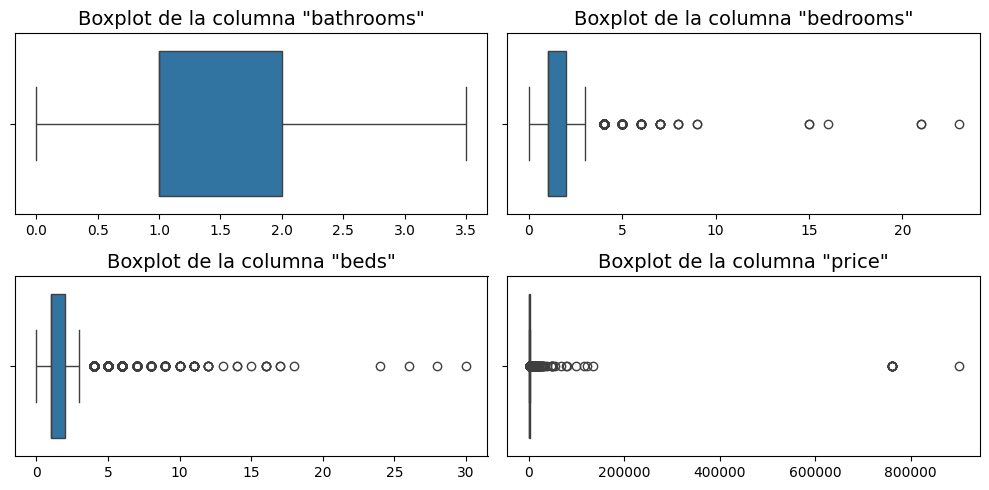

In [307]:
# Lista de columnas que quieres visualizar
cols_outliers = ['bathrooms', 'bedrooms', 'beds', 'price']

# Crear una figura y un conjunto de subplots (2 filas, 2 columnas)
# figsize ajusta el tamaño total de la figura para que se vea bien
fig, axes = plt.subplots(2, 2, figsize=(10, 5))

# Aplanar el array de ejes para iterar fácilmente sobre él
axes = axes.flatten()

# Iterar sobre cada columna y su eje correspondiente para dibujar el boxplot
for i, col in enumerate(cols_outliers):
    sns.boxplot(x=df_trans[col], ax=axes[i])
    axes[i].set_title(f'Boxplot de la columna "{col}"', fontsize=14)
    axes[i].set_xlabel('') # Opcional: limpiar la etiqueta del eje x si es redundante

# Ajustar el layout para que los gráficos no se superpongan
plt.tight_layout()

# Mostrar el gráfico
plt.show()

In [308]:
# Definir umbrales razonables y diferentes para cada columna
limites = {
    'bathrooms': 10,
    'bedrooms': 10,
    'beds': 15,
    'price': 400000  # Ejemplo: un precio máximo que consideres razonable
}

# Crear un filtro para cada columna y combinarlos con un "OR" lógico
filtro_bath = df_trans['bathrooms'] > limites['bathrooms']
filtro_bedr = df_trans['bedrooms'] > limites['bedrooms']
filtro_beds = df_trans['beds'] > limites['beds']
filtro_price = df_trans['price'] > limites['price']

# Combinar los filtros: una fila se eliminará si CUALQUIERA de las condiciones es verdadera
filtro_total = filtro_bath | filtro_bedr | filtro_beds | filtro_price

print(f"Filas a eliminar por superar los límites manuales: {filtro_total.sum()}")

# Aplicar el filtro
df_limpio = df_trans[~filtro_total].copy()

print(f"DataFrame final: {df_limpio.shape[0]} filas y {df_limpio.shape[1]} columnas")

Filas a eliminar por superar los límites manuales: 29
DataFrame final: 22494 filas y 87 columnas


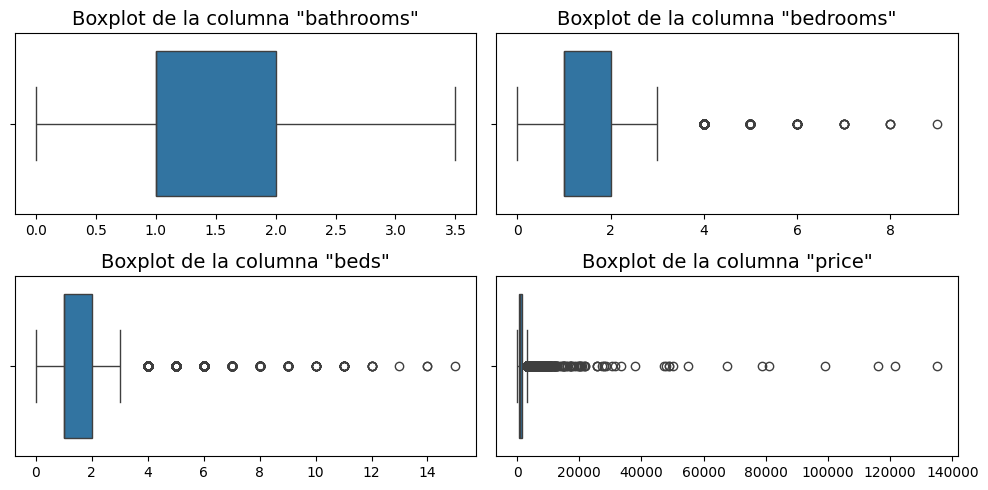

In [309]:
# Lista de columnas que quieres visualizar
cols_outliers = ['bathrooms', 'bedrooms', 'beds', 'price']

# Crear una figura y un conjunto de subplots (2 filas, 2 columnas)
# figsize ajusta el tamaño total de la figura para que se vea bien
fig, axes = plt.subplots(2, 2, figsize=(10, 5))

# Aplanar el array de ejes para iterar fácilmente sobre él
axes = axes.flatten()

# Iterar sobre cada columna y su eje correspondiente para dibujar el boxplot
for i, col in enumerate(cols_outliers):
    sns.boxplot(x=df_limpio[col], ax=axes[i])
    axes[i].set_title(f'Boxplot de la columna "{col}"', fontsize=14)
    axes[i].set_xlabel('') # Opcional: limpiar la etiqueta del eje x si es redundante

# Ajustar el layout para que los gráficos no se superpongan
plt.tight_layout()

# Mostrar el gráfico
plt.show()

#### Manejar el resto de nulos

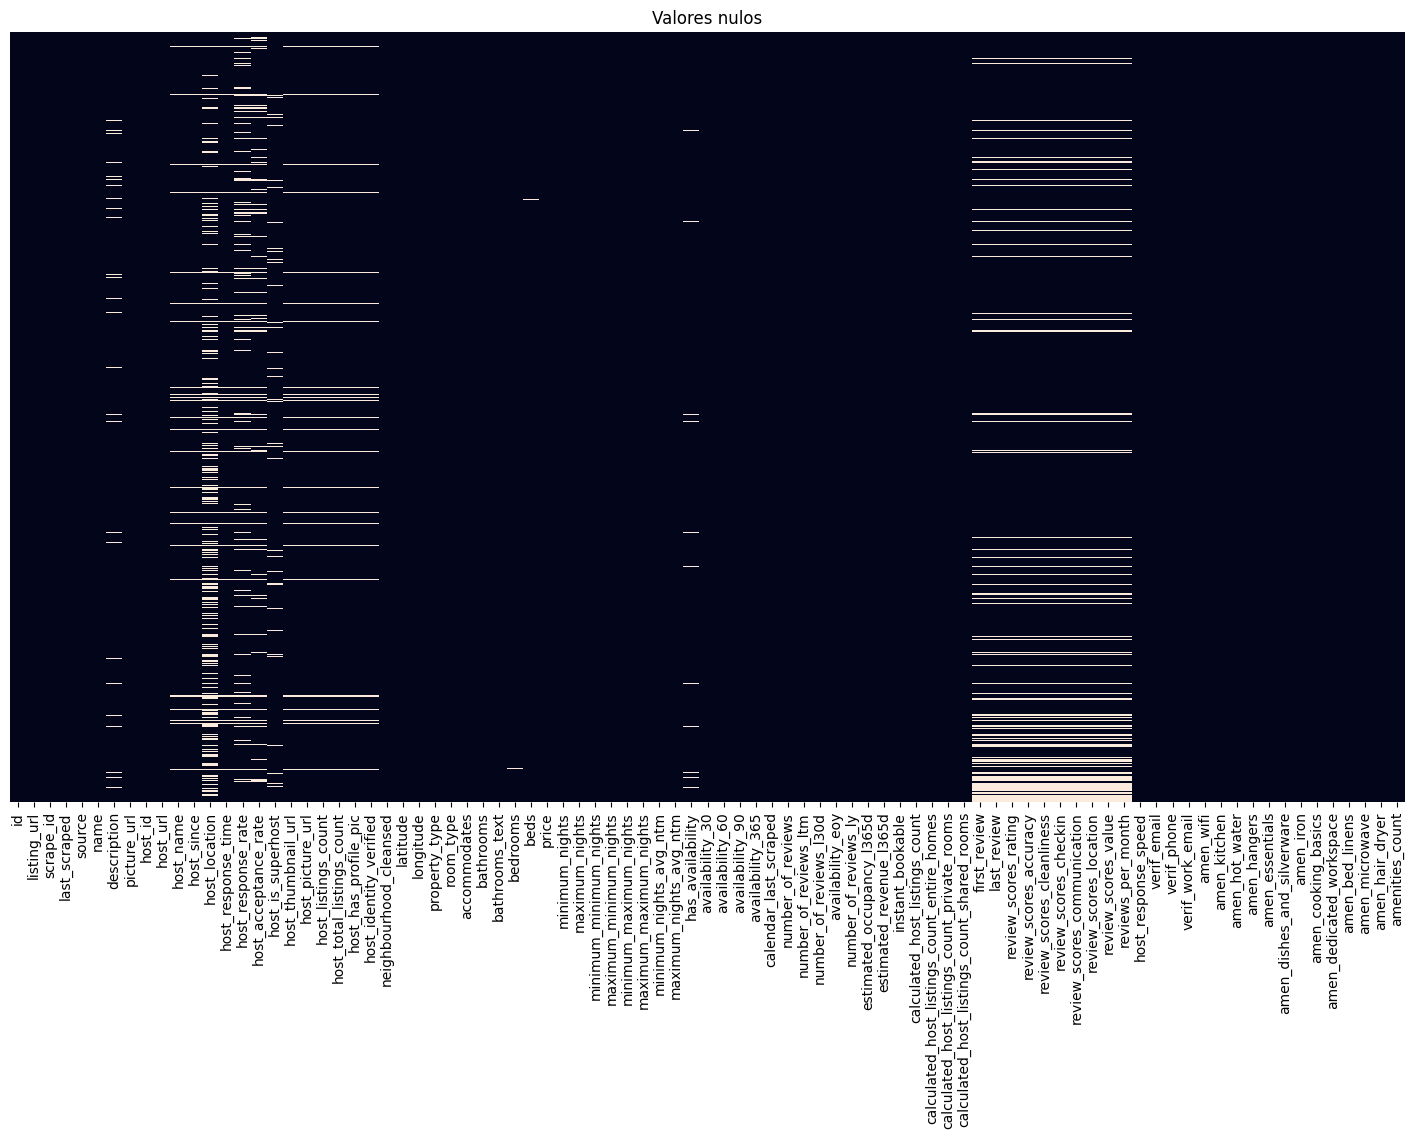

In [310]:
plt.figure(figsize=(18, 10))
sns.heatmap(df_limpio.isnull(), cbar=False, yticklabels=False)
plt.title('Valores nulos')
plt.show()

In [311]:
df_limpio.isnull().sum()

id                                                 0
listing_url                                        0
scrape_id                                          0
last_scraped                                       0
source                                             0
name                                               0
description                                      578
picture_url                                        0
host_id                                            0
host_url                                           0
host_name                                        824
host_since                                       874
host_location                                   5225
host_response_time                               874
host_response_rate                              2845
host_acceptance_rate                            2126
host_is_superhost                               1173
host_thumbnail_url                               874
host_picture_url                              

In [312]:
# Columnas de puntuaciones de reviews
cols_scores = [
    'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 
    'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 
    'review_scores_value'
]
# Rellenar con 0
for col in cols_scores:
    if col in df_limpio.columns:
        df_limpio[col].fillna(0, inplace=True)
print("Columnas de 'review_scores' rellenadas con 0.")

# Rellenar reviews_per_month con 0
if 'reviews_per_month' in df_limpio.columns:
    df_limpio['reviews_per_month'].fillna(0, inplace=True)
    print("Columna 'reviews_per_month' rellenada con 0.")

# Eliminar las columnas de fechas de reviews
df_limpio.drop(columns=['first_review', 'last_review'], inplace=True, errors='ignore')
print("Columnas de fechas de reviews eliminadas.")

Columnas de 'review_scores' rellenadas con 0.
Columna 'reviews_per_month' rellenada con 0.
Columnas de fechas de reviews eliminadas.


In [313]:
# Lista de columnas de host con nulos para eliminar
cols_host_a_eliminar = [
    'host_name', 'host_since', 'host_location', 'host_response_time', 
    'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 
    'host_thumbnail_url', 'host_picture_url', 'host_listings_count',
    'host_total_listings_count', 'host_has_profile_pic', 'host_identity_verified'
]

df_limpio.drop(columns=cols_host_a_eliminar, inplace=True, errors='ignore')
print("Columnas del anfitrión con nulos eliminadas.")

Columnas del anfitrión con nulos eliminadas.


In [314]:
# Columnas de atributos para imputar
cols_atributos = ['bedrooms', 'beds', 'bathrooms']

for col in cols_atributos:
    if col in df_limpio.columns and df_limpio[col].isnull().sum() > 0:
        mediana = df_limpio[col].median()
        df_limpio[col].fillna(mediana, inplace=True)
        print(f"Nulos en '{col}' rellenados con la mediana ({mediana}).")

# La columna bathrooms_text ya no es necesaria si bathrooms está limpia
df_limpio.drop(columns=['bathrooms_text'], inplace=True, errors='ignore')

Nulos en 'bedrooms' rellenados con la mediana (1.0).
Nulos en 'beds' rellenados con la mediana (1.0).


In [315]:
df_limpio.drop(columns=['description'], inplace=True, errors='ignore')
print("Columna 'description' eliminada.")

Columna 'description' eliminada.


In [316]:
# Verificar los nulos restantes
nulos_restantes = df_limpio.isnull().sum()
nulos_restantes = nulos_restantes[nulos_restantes > 0]

if nulos_restantes.empty:
    print("\n¡Felicidades! No quedan valores nulos en el DataFrame.")
else:
    print("\n¡Atención! Aún quedan valores nulos en las siguientes columnas:")
    print(nulos_restantes)

print(f"\nForma final del DataFrame: {df_limpio.shape}")


¡Atención! Aún quedan valores nulos en las siguientes columnas:
minimum_minimum_nights     18
maximum_minimum_nights     18
minimum_maximum_nights     18
maximum_maximum_nights     18
has_availability          225
dtype: int64

Forma final del DataFrame: (22494, 70)


In [317]:
cols_nights_a_eliminar = [
    'minimum_minimum_nights',
    'maximum_minimum_nights',
    'minimum_maximum_nights',
    'maximum_maximum_nights'
]

df_limpio.drop(columns=cols_nights_a_eliminar, inplace=True, errors='ignore')
print("Columnas complejas de 'nights' eliminadas.")

# --- Rellenar y convertir 'has_availability' ---

if 'has_availability' in df_limpio.columns:
    # Rellenar nulos con la moda
    if df_limpio['has_availability'].isnull().sum() > 0:
        moda_availability = df_limpio['has_availability'].mode()[0]
        df_limpio['has_availability'].fillna(moda_availability, inplace=True)
        print(f"Nulos en 'has_availability' rellenados con la moda ('{moda_availability}').")

    # Convertir la columna a 0s y 1s (si es 't'/'f')
    # Esto también manejará True/False booleanos.
    if df_limpio['has_availability'].dtype == 'object':
        df_limpio['has_availability'] = df_limpio['has_availability'].apply(lambda x: 1 if x == 't' else 0).astype(int)
        print("Columna 'has_availability' convertida a formato numérico (0/1).")
    elif pd.api.types.is_bool_dtype(df_limpio['has_availability']):
        df_limpio['has_availability'] = df_limpio['has_availability'].astype(int)
        print("Columna 'has_availability' convertida a formato numérico (0/1).")

Columnas complejas de 'nights' eliminadas.
Nulos en 'has_availability' rellenados con la moda ('True').
Columna 'has_availability' convertida a formato numérico (0/1).

Nulos en 'has_availability' rellenados con la moda ('True').
Columna 'has_availability' convertida a formato numérico (0/1).


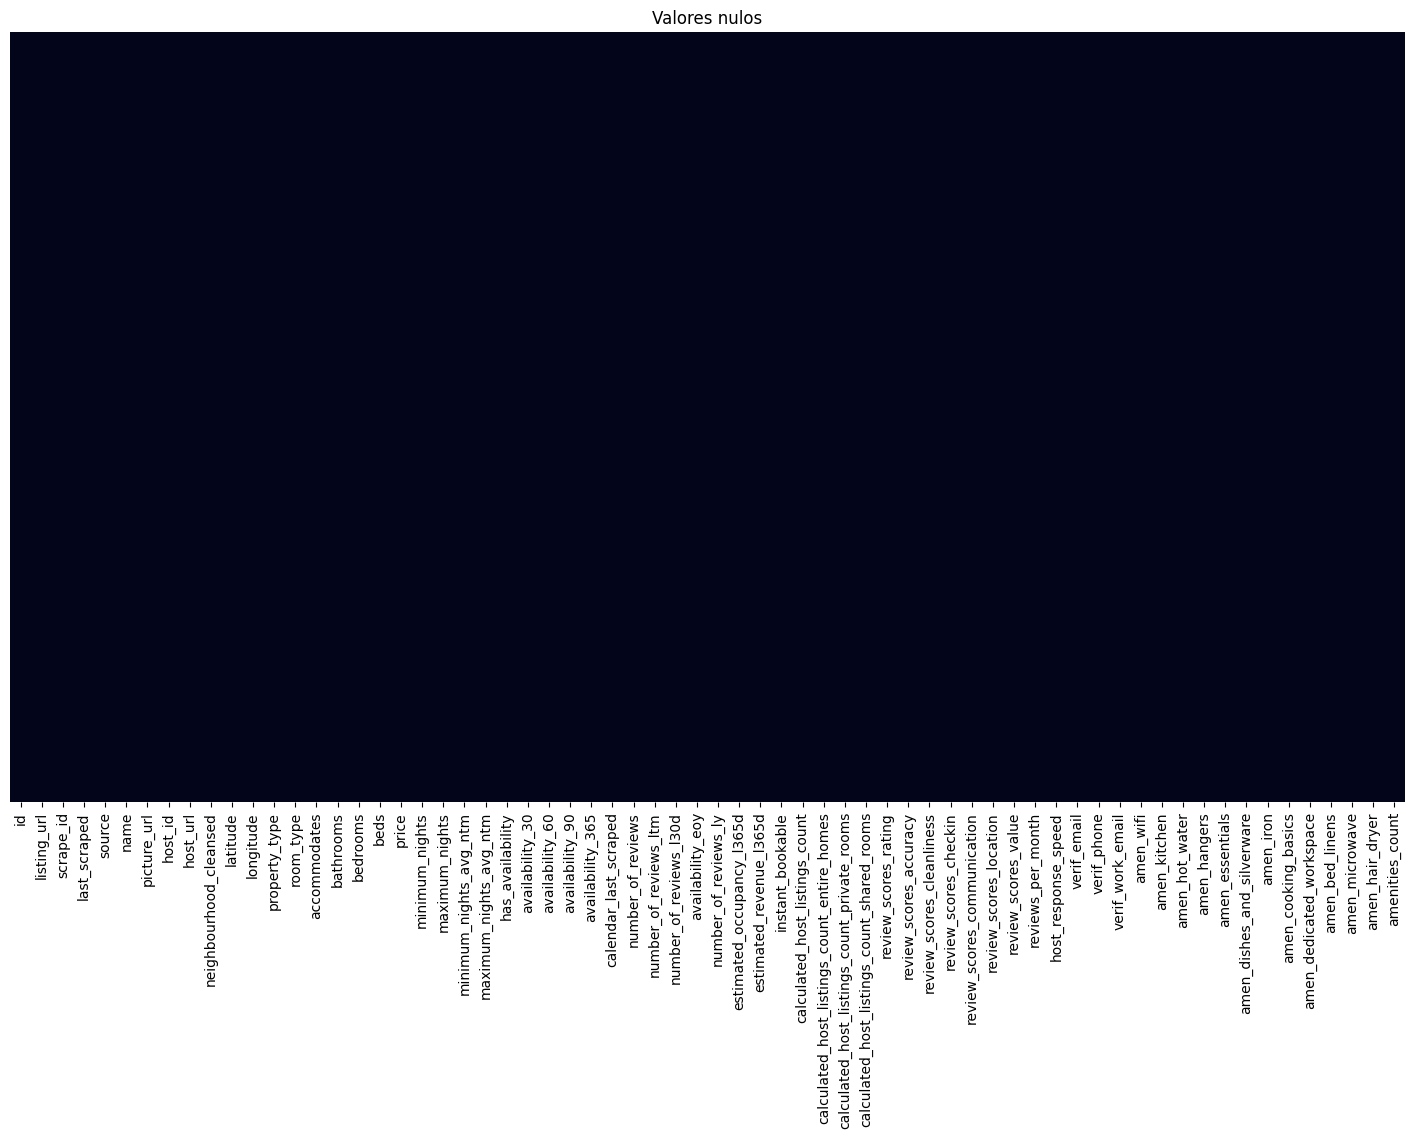

In [318]:
plt.figure(figsize=(18, 10))
sns.heatmap(df_limpio.isnull(), cbar=False, yticklabels=False)
plt.title('Valores nulos')
plt.show()

In [319]:
#imprmir registros antes y despues de la limpieza de datos
print(f"Registros antes de la limpieza: {df_listings.shape[0]}")
print(f"Registros después de la limpieza: {df_limpio.shape[0]}")

Registros antes de la limpieza: 26401
Registros después de la limpieza: 22494


# Reviews

## Exploración de Datos de Reviews

In [320]:
# Exploración inicial de los datos de reviews
print("Exploración de la muestra de datos de reviews:")
display(df_reviews.head())
print("\nInformación del DataFrame de reviews:")
df_reviews.info()

Exploración de la muestra de datos de reviews:


,listing_id,id,date,reviewer_id,reviewer_name,comments,sentimiento,puntuacion_sentimiento
0,10257549,59265221,2016-01-08,31043833,Karolis,The flat is very nice newly renovated. The hos...,Positivo,0.9170
1,10257549,59352234,2016-01-09,7248934,James,Benito and his wife were great guests. Perfect...,Positivo,0.9386
2,10257549,59456981,2016-01-10,52707457,Manuel,Fue algo express. No pude volar y contacté con...,Neutral,0.0000
3,10257549,59661086,2016-01-13,52989229,Annie,This was a very comfortable and conveniently l...,Positivo,0.9863
4,10257549,59806795,2016-01-15,51159033,Svenja,"Nice place, really close to te airport - Nice ...",Positivo,0.6808



Información del DataFrame de reviews:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   listing_id              15000 non-null  int64         
 1   id                      15000 non-null  int64         
 2   date                    15000 non-null  datetime64[ns]
 3   reviewer_id             15000 non-null  int64         
 4   reviewer_name           15000 non-null  object        
 5   comments                15000 non-null  object        
 6   sentimiento             15000 non-null  object        
 7   puntuacion_sentimiento  15000 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 937.6+ KB


### manejo de nulos

In [321]:
df_reviews.isnull().sum()

listing_id                0
id                        0
date                      0
reviewer_id               0
reviewer_name             0
comments                  0
sentimiento               0
puntuacion_sentimiento    0
dtype: int64

### cambio de tipo de dato de object a datetime

In [322]:
df_reviews['date'] = pd.to_datetime(df_reviews['date'], errors='coerce')

df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   listing_id              15000 non-null  int64         
 1   id                      15000 non-null  int64         
 2   date                    15000 non-null  datetime64[ns]
 3   reviewer_id             15000 non-null  int64         
 4   reviewer_name           15000 non-null  object        
 5   comments                15000 non-null  object        
 6   sentimiento             15000 non-null  object        
 7   puntuacion_sentimiento  15000 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 937.6+ KB


### Análisis de Sentimiento Multilingüe

In [323]:
df_reviews_sample = df_reviews_completo.head(15000).copy()

# Configuración para análisis de sentimiento
DetectorFactory.seed = 0
try:
    nltk.data.find('sentiment/vader_lexicon.zip')
except LookupError:
    nltk.download('vader_lexicon')

vader_analyzer = SentimentIntensityAnalyzer()

def clasificar_sentimiento_multilingue(comentario):
    if pd.isna(comentario) or str(comentario).strip() == "":
        return 'Neutral', 0.0

    comentario_str = str(comentario).strip()
    score = 0.0
    
    try:
        lang = detect(comentario_str)
    except:
        lang = 'unk' # Idioma desconocido

    try:
        if lang == 'es':
            score = TextBlob(comentario_str).sentiment.polarity
        else:
            score = vader_analyzer.polarity_scores(comentario_str)['compound']
    except:
        score = 0.0
    
    if score >= 0.05:
        sentimiento = 'Positivo'
    elif score <= -0.05:
        sentimiento = 'Negativo'
    else:
        sentimiento = 'Neutral'
        
    return sentimiento, score

# Aplicar la función a la columna 'comments' del DataFrame de reviews
df_reviews_sample[['sentimiento', 'puntuacion_sentimiento']] = df_reviews_sample['comments'].apply(
    lambda x: pd.Series(clasificar_sentimiento_multilingue(x))
)

print("\nDataFrame de reviews con la clasificación de sentimientos:")
display(df_reviews_sample[['comments', 'puntuacion_sentimiento', 'sentimiento']].head())


DataFrame de reviews con la clasificación de sentimientos:


,comments,puntuacion_sentimiento,sentimiento
0,The flat is very nice newly renovated. The hos...,0.9170,Positivo
1,Benito and his wife were great guests. Perfect...,0.9386,Positivo
2,Fue algo express. No pude volar y contacté con...,0.0000,Neutral
3,This was a very comfortable and conveniently l...,0.9863,Positivo
4,"Nice place, really close to te airport - Nice ...",0.6808,Positivo


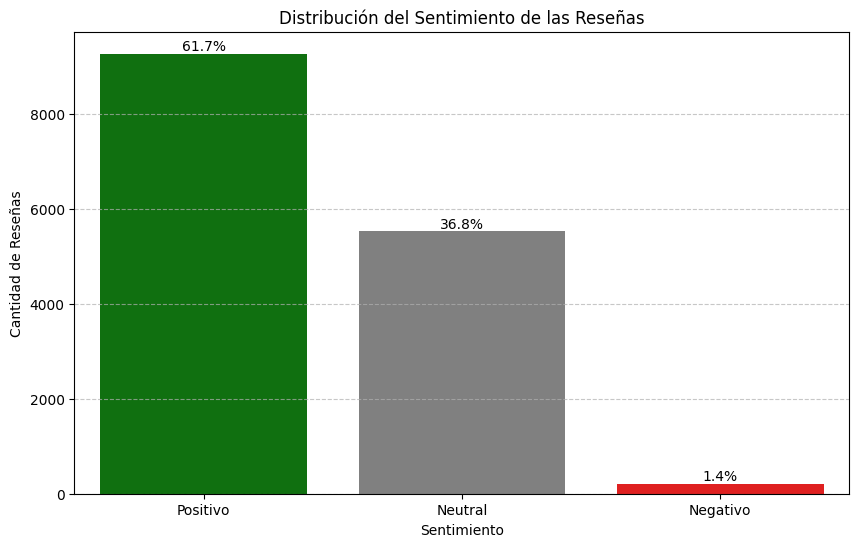

In [324]:
# Visualización de la distribución de sentimientos
plt.figure(figsize=(10, 6))
palette = {'Positivo': 'green', 'Neutral': 'gray', 'Negativo': 'red'}
ax = sns.countplot(x='sentimiento', data=df_reviews_sample, order=['Positivo', 'Neutral', 'Negativo'], palette=palette)

total = len(df_reviews_sample)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

plt.title('Distribución del Sentimiento de las Reseñas')
plt.xlabel('Sentimiento')
plt.ylabel('Cantidad de Reseñas')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Calendar

## Análisis y Limpieza de `calendar`

In [325]:
display(df_calendar.head())
df_calendar.info()

,listing_id,date,available,year,month,day
0,35797,2025-06-26,0,2025,6,26
1,35797,2025-06-27,1,2025,6,27
2,35797,2025-06-28,1,2025,6,28
3,35797,2025-06-29,1,2025,6,29
4,35797,2025-06-30,1,2025,6,30


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9636365 entries, 0 to 9636364
Data columns (total 6 columns):
 #   Column      Dtype         
---  ------      -----         
 0   listing_id  int64         
 1   date        datetime64[ns]
 2   available   int64         
 3   year        int32         
 4   month       int32         
 5   day         int32         
dtypes: datetime64[ns](1), int32(3), int64(2)
memory usage: 330.8 MB


### Manejo de nulos

In [326]:
df_calendar.isnull().sum()

listing_id    0
date          0
available     0
year          0
month         0
day           0
dtype: int64

### Transformación de los datos

In [327]:
# Creación de columnas de año, mes y día
df_calendar['year'] = df_calendar['date'].dt.year
df_calendar['month'] = df_calendar['date'].dt.month
df_calendar['day'] = df_calendar['date'].dt.day

# Conversión de 'available' a formato numérico (si es necesario)
if df_calendar['available'].dtype == bool:
    df_calendar['available'] = df_calendar['available'].astype(int)
elif df_calendar['available'].dtype == object and set(df_calendar['available'].unique()) <= {'t', 'f'}:
    df_calendar['available'] = df_calendar['available'].apply(lambda x: 1 if x == 't' else 0).astype(int)

# Eliminación de columnas no deseadas
df_calendar.drop(columns=['minimum_nights', 'maximum_nights'], inplace=True, errors='ignore')

print("\nDataFrame del calendario transformado:")
display(df_calendar.head())


DataFrame del calendario transformado:


,listing_id,date,available,year,month,day
0,35797,2025-06-26,0,2025,6,26
1,35797,2025-06-27,1,2025,6,27
2,35797,2025-06-28,1,2025,6,28
3,35797,2025-06-29,1,2025,6,29
4,35797,2025-06-30,1,2025,6,30


# Agregación y Unión de Datos

## Agregación de puntuaciones de sentimiento

In [328]:
print("Agregando datos de reviews...")
sentiment_por_listing = df_reviews_sample.groupby('listing_id').agg(
    sentimiento_promedio=('puntuacion_sentimiento', 'mean'),
    numero_de_reviews_sentimiento=('puntuacion_sentimiento', 'count')
).reset_index()
sentiment_por_listing['sentimiento_promedio'] = sentiment_por_listing['sentimiento_promedio'].round(4)
sentiment_por_listing.rename(columns={'listing_id': 'id'}, inplace=True)
print("Agregación de reviews completada.")

Agregando datos de reviews...
Agregación de reviews completada.


## Agregación de Datos de Disponibilidad

In [329]:
print("Agregando datos de calendar...")
calendar_agg = df_calendar.groupby('listing_id').agg(
    tasa_disponibilidad_anual=('available', 'mean'),
    dias_disponibles_anual=('available', 'sum')
).reset_index()
calendar_agg['tasa_disponibilidad_anual'] = (calendar_agg['tasa_disponibilidad_anual'] * 100).round(2)
calendar_agg.rename(columns={'listing_id': 'id'}, inplace=True)
print("Agregación completada.")

Agregando datos de calendar...
Agregación completada.
Agregación completada.


## Merge final

In [330]:
print("Combinando df_limpio con agregados de reviews y calendar...")
df_final = df_limpio.merge(sentiment_por_listing, on='id', how='left')
df_final = df_final.merge(calendar_agg, on='id', how='left')

# Limpieza de nulos post-unión
print("Rellenando nulos generados por la unión...")
df_final['sentimiento_promedio'].fillna(0, inplace=True)
df_final['numero_de_reviews_sentimiento'].fillna(0, inplace=True)
df_final['tasa_disponibilidad_anual'].fillna(0, inplace=True)
df_final['dias_disponibles_anual'].fillna(0, inplace=True)

# 4.3. Ajuste de tipos de datos final
df_final['numero_de_reviews_sentimiento'] = df_final['numero_de_reviews_sentimiento'].astype(int)
df_final['dias_disponibles_anual'] = df_final['dias_disponibles_anual'].astype(int)
print("Unión y limpieza final completadas.")


# ==============================================================================
# VERIFICACIÓN FINAL
# ==============================================================================
print("\n--- Verificación del DataFrame Final ---")
print(f"Dimensiones del DataFrame final y completo: {df_final.shape}")
print("Mostrando una selección de columnas originales y las nuevas características:")

columnas_a_verificar = [
    'id', 'name', 'price', 
    'sentimiento_promedio', 'numero_de_reviews_sentimiento', 
    'tasa_disponibilidad_anual', 'dias_disponibles_anual'
]
# Asegurarnos de que las columnas existan antes de mostrarlas
columnas_existentes = [col for col in columnas_a_verificar if col in df_final.columns]
display(df_final[columnas_existentes].head())

Combinando df_limpio con agregados de reviews y calendar...
Rellenando nulos generados por la unión...
Unión y limpieza final completadas.

--- Verificación del DataFrame Final ---
Dimensiones del DataFrame final y completo: (22494, 70)
Mostrando una selección de columnas originales y las nuevas características:


,id,name,price,sentimiento_promedio,numero_de_reviews_sentimiento,tasa_disponibilidad_anual,dias_disponibles_anual
0,35797,Villa Dante,3799.0,0.0000,0,99.73,364
1,56074,Great space in historical San Rafael,585.0,0.6701,84,92.60,338
2,67703,"2 bedroom apt. deco bldg, Condesa",1696.0,0.8729,50,73.15,267
3,70644,Beautiful light Studio Coyoacan- full equipped !,1004.0,0.8195,132,57.81,211
4,171109,Cool room near WTC and Metrobus,315.0,0.2374,117,97.26,355


### Principales hallazgos del estudio
- Se detectaron **inconsistencias estructurales**: `amenities` y `host_verifications` llegaban como cadenas; tras normalizarlas se generaron variables binarias y un conteo total, lo que permitió identificar las 12 amenidades más frecuentes.
- Las columnas del anfitrión presentaban **más del 40 % de datos faltantes**, por lo que se eliminaron; las tasas de respuesta y aceptación se estandarizaron y la velocidad de respuesta quedó resumida en `host_response_speed`.
- El precio incluía símbolos monetarios y miles; se limpió y se **controlaron outliers** con IQR y límites manuales (`price`, `beds`, `bedrooms`, `bathrooms`), estabilizando las distribuciones mostradas en los boxplots.
- El análisis de sentimiento multilingüe reveló un **predominio de reseñas positivas**, con soporte visual en el gráfico de barras y métricas agregadas (`sentimiento_promedio`, `numero_de_reviews_sentimiento`).
- La agregación del calendario permitió cuantificar la **disponibilidad anual** (`tasa_disponibilidad_anual`, `dias_disponibles_anual`), facilitando comparativas entre ofertas con alta ocupación frente a inventario ocioso.
- El `df_final` resultante mantiene la llave `id` y consolida atributos limpios, sentimiento y disponibilidad, sirviendo como base para modelos analíticos o cargas posteriores.